In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

import text_utilities
import deep_learning_utils

from collections import Counter
import os
import random
import re
import string
import time

seed = 2137

random.seed = seed
tf.random.set_seed(seed)
np.random.seed(seed)

2024-05-28 12:48:36.510148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset Import

In [2]:
dataset_path = os.path.join('data/articles', 'articles_23-05-2024_12h13m03s.csv')

df = pd.read_csv(dataset_path, index_col=0)

In [3]:
df['full_text'] = df['title'] + ' ' + df['summary']

In [4]:
df = df.dropna(subset=['full_text'])
df = df.dropna(subset='relevant')

In [5]:
df['full_text_clean'] = text_utilities.text_cleaning_pd_series(df['full_text'], lemmatization=True)

In [6]:
df.shape

(2316, 19)

/var/folders/s4/67mds2cx77j5lthp_x3dx4dw0000gn/T/ipykernel_88599/3985979669.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, df.relevant.value_counts()[i], df.relevant.value_counts()[i], ha = 'center')
/var/folders/s4/67mds2cx77j5lthp_x3dx4dw0000gn/T/ipykernel_88599/3985979669.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, df.relevant.value_counts()[i], df.relevant.value_counts()[i], ha = 'center')
/var/folders/s4/67mds2cx77j5lthp_x3dx4dw0000gn/T/ipykernel_88599/3985979669.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer key

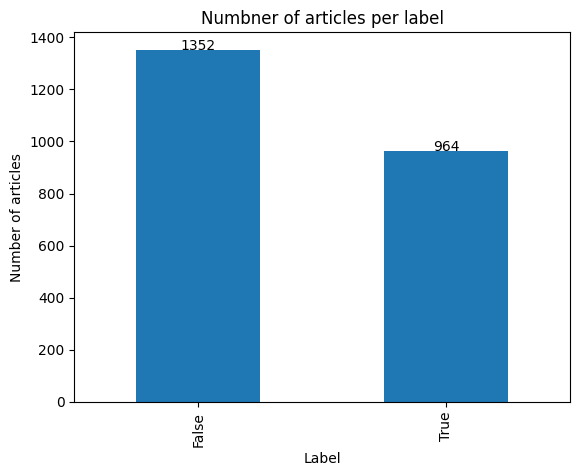

In [7]:
df.relevant.value_counts().plot(kind='bar')

for i in range(len(df.relevant.value_counts())):
    plt.text(i, df.relevant.value_counts()[i], df.relevant.value_counts()[i], ha = 'center')
plt.title('Numbner of articles per label')
plt.xlabel('Label')
plt.ylabel('Number of articles')
plt.show()



In [8]:
data = df[['full_text_clean', 'relevant']]

In [9]:
data.dropna(inplace=True)

/var/folders/s4/67mds2cx77j5lthp_x3dx4dw0000gn/T/ipykernel_88599/1368182302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [10]:
# encode relevant table to 0 and 1 - relevant = 1

data['relevant'] = data['relevant'].apply(lambda x: 1 if x == True else 0)

/var/folders/s4/67mds2cx77j5lthp_x3dx4dw0000gn/T/ipykernel_88599/2832208477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['relevant'] = data['relevant'].apply(lambda x: 1 if x == True else 0)


Text(0, 0.5, 'Number of articles')

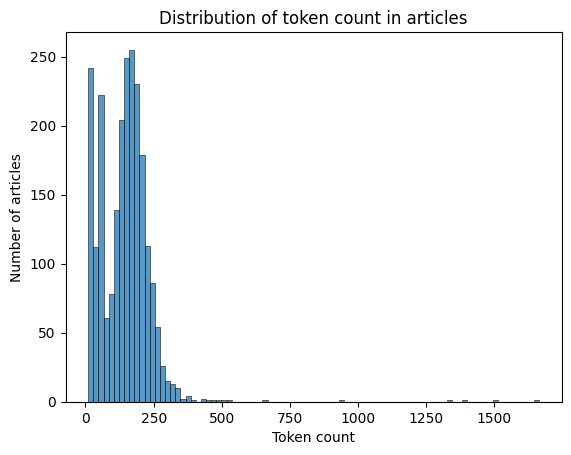

In [11]:
sns.histplot(data['full_text_clean'].apply(lambda x: len(x.split())))
plt.title('Distribution of token count in articles')
plt.xlabel('Token count')
plt.ylabel('Number of articles')

## Train/Val/Test split with seed

In [12]:
train, test = train_test_split(data, test_size=0.2, random_state=seed, shuffle=True, stratify=data['relevant'])

train, val = train_test_split(train, test_size=0.2, random_state=seed, shuffle=True, stratify=train['relevant'])

## Train Vocabulary Size

In [13]:
def unique_word_count(strings, top_percent=100):
    # Combine all strings into one large string
    all_text = ' '.join(strings)

    # Split the string into words
    words = all_text.split()

    # Count the frequency of each word
    word_counts = Counter(words)

    # If top_percent is 100, return the total unique words
    if top_percent == 100:
        return len(word_counts)

    # Get the frequencies of the words
    frequencies = list(word_counts.values())

    # Calculate the threshold for the top percent
    threshold = np.percentile(frequencies, 100 - top_percent)

    # Count the words that meet the frequency threshold
    filtered_words = [word for word, count in word_counts.items() if count >= threshold]

    return len(filtered_words)

In [14]:
vocab_size = unique_word_count(train['full_text_clean'], top_percent=80)

## Tensorflow dataset creation

In [15]:
# creation of tensorflow datasetse from train val and test

train_ds = tf.data.Dataset.from_tensor_slices((train['full_text_clean'].values, train['relevant'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val['full_text_clean'].values, val['relevant'].values))
test_ds = tf.data.Dataset.from_tensor_slices((test['full_text_clean'].values, test['relevant'].values))

train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

## Optimize the dataset

In [16]:
## Optimize the dataset

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modeling

## Modeling Utilities

### Vectorisation layer

In [17]:
output_dim = 256

def custom_standardization(input_text):
    """Lowercase and remove punctuation from the text."""
    lowercase_text = tf.strings.lower(input_text)
    cleaned_text = tf.strings.regex_replace(lowercase_text, '[%s]' % re.escape(string.punctuation), '')
    return cleaned_text

# Create the TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=output_dim,
    standardize=custom_standardization
)

# Assuming `texts` is a list or dataset of your text data
vectorize_layer.adapt(train['full_text_clean'])

### Model Registry

In [18]:
path_to_registry = r'model_results_table.csv'

if os.path.exists(path_to_registry):
    model_registry = pd.read_csv(path_to_registry, index_col=0).reset_index(drop=False)
else:
    model_registry = None

## RNN Models

In [19]:
keras.backend.clear_session()

In [20]:
metrics = ['accuracy', 'recall', 'precision', 'AUC']

epochs=20

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True, verbose=1)

### Single Layer RNN Model (No Regularisation)

In [21]:
model_rnn_1 = deep_learning_utils.create_rnn_model(vectorize_layer=vectorize_layer,
                               embedding_dim=200,
                               rnn_units=32,
                               num_rnn_layers=1,
                               num_classes=1,
                               seed=seed,
                               dropout_rate=0,
                               l2_lambda=0,
                               metrics = metrics)

model_rnn_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn          │ (None, 32)        │      7,456 │ embedding[0][0],  │
│ (SimpleRNN)         │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ simple_rnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         33 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,342,489 (16.57 MB)

 Trainable params: 4,342,489 (16.57 MB)

 Non-trainable params: 0 (0.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 258ms/step - AUC: 0.5836 - accuracy: 0.6128 - loss: 0.6660 - precision: 0.6114 - recall: 0.1496 - val_AUC: 0.8591 - val_accuracy: 0.8027 - val_loss: 0.4875 - val_precision: 0.8534 - val_recall: 0.6387
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - AUC: 0.9941 - accuracy: 0.9464 - loss: 0.2299 - precision: 0.9762 - recall: 0.8903 - val_AUC: 0.8481 - val_accuracy: 0.7865 - val_loss: 0.4827 - val_precision: 0.7603 - val_recall: 0.7161
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.0318 - precision: 1.0000 - recall: 1.0000 - val_AUC: 0.8160 - val_accuracy: 0.7486 - val_loss: 0.5272 - val_precision: 0.7013 - val_recall: 0.6968
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.0115 - precision: 1.0000 - recall: 1.0000 - val_AUC: 0.8116 - val_accuracy: 0.7541 - val_loss: 0.5399 - val_precision: 0.7105 - val_recall

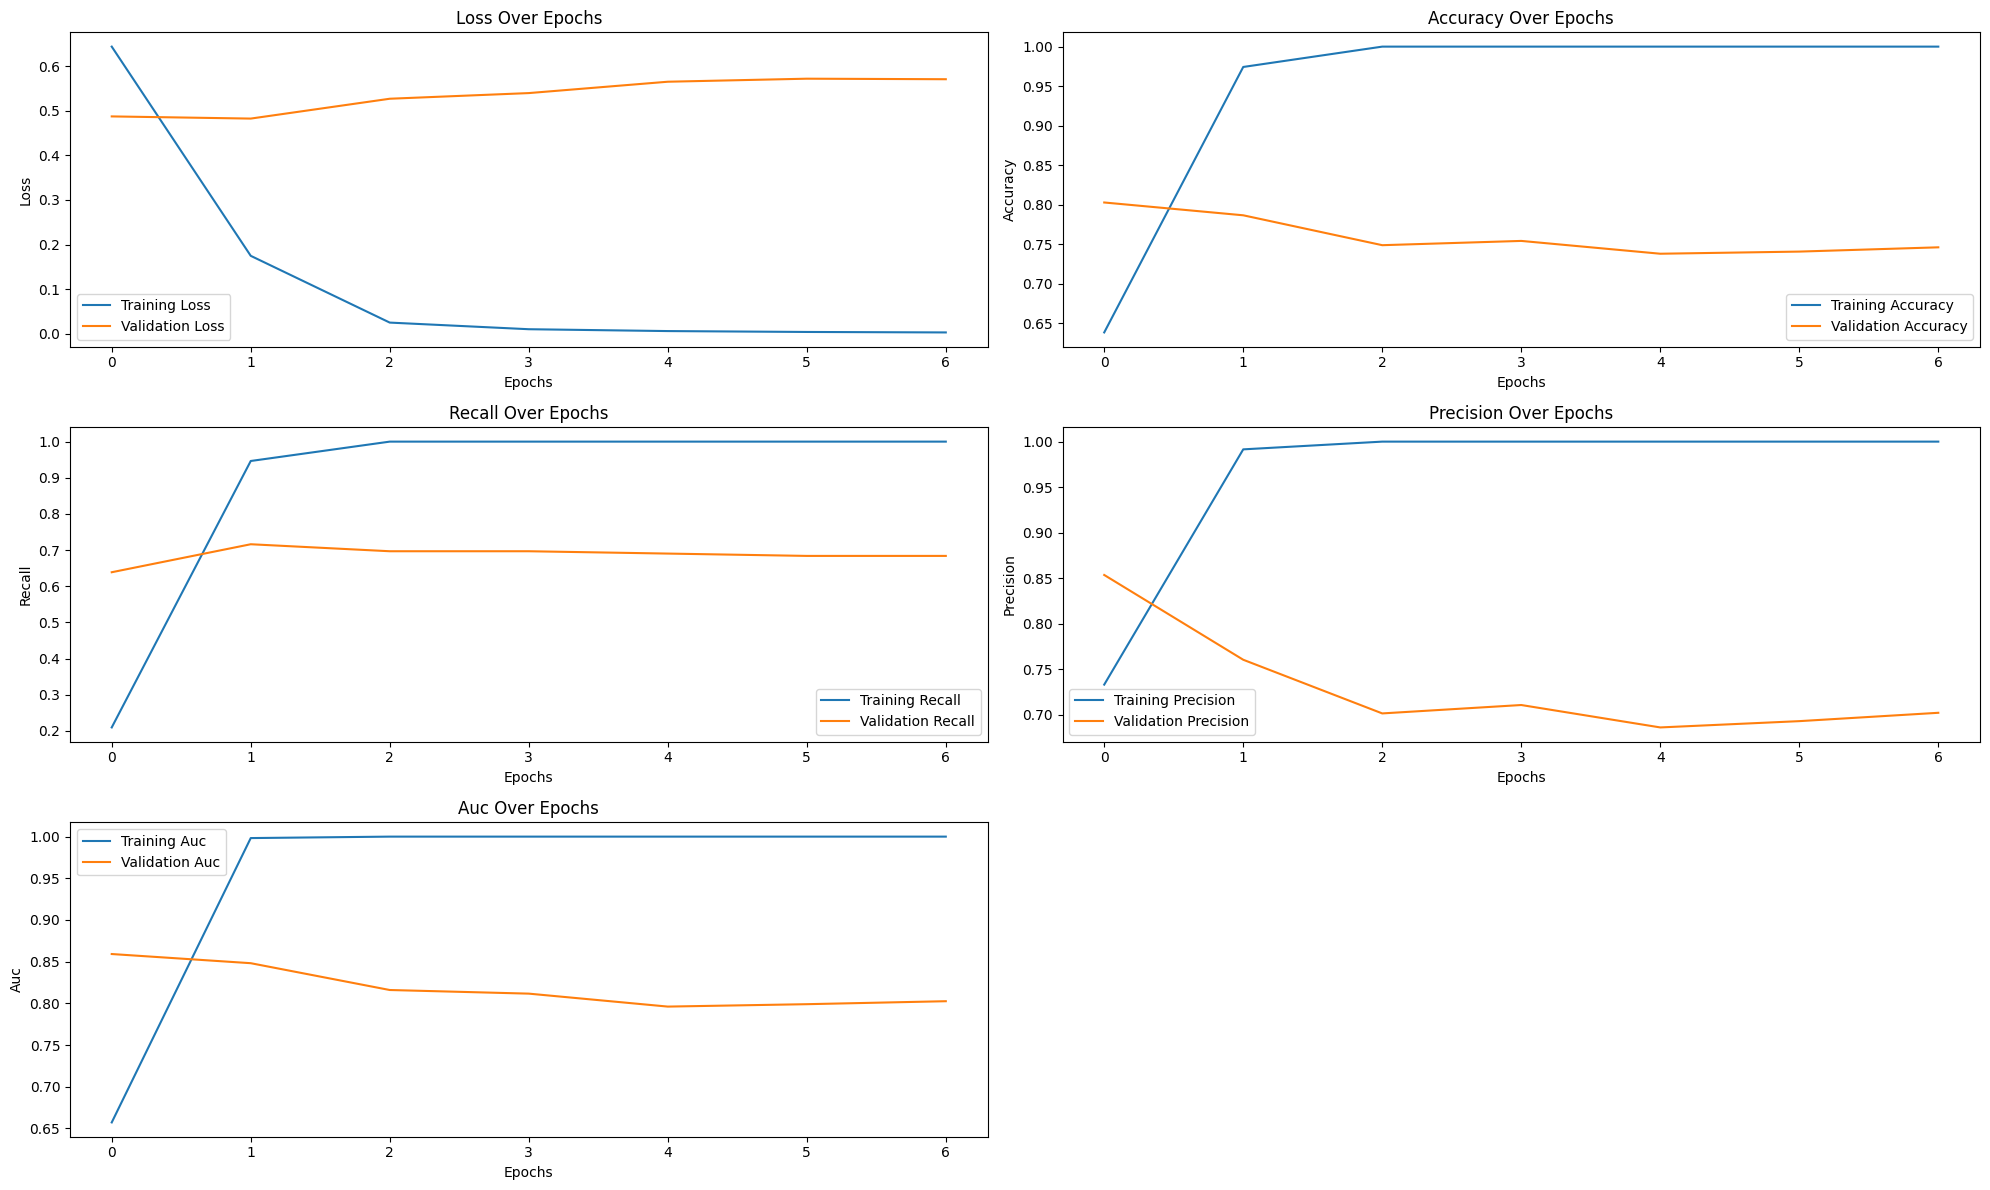


Final Training Loss: 0.0028
Final Validation Loss: 0.5710

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.7459

Final Training Recall: 1.0000
Final Validation Recall: 0.6839

Final Training Precision: 1.0000
Final Validation Precision: 0.7020

Final Training Auc: 1.0000
Final Validation Auc: 0.8025


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - AUC: 0.8259 - accuracy: 0.7425 - loss: 0.5069 - precision: 0.7025 - recall: 0.6702
{'AUC': 0.8212724328041077, 'accuracy': 0.7467532753944397, 'loss': 0.5124505758285522, 'precision': 0.7111111283302307, 'recall': 0.6632124185562134}
Test Loss: 0.5124505758285522
Test Accuracy: 0.7467532753944397
Test Recall: 0.6632124185562134
Test Precision: 0.7111111283302307
Test Auc: 0.8212724328041077


In [22]:
model_description = 'One Layer RNN (32), No Regularisation, Embeddings size: 200'


model_registry = deep_learning_utils.train_plot_and_evaluate(model_rnn_1, 
                                            train_ds, 
                                            val_ds, 
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

In [23]:
model_registry

,n_epochs,avg_epoch_time,test_loss,test_accuracy,test_recall,test_precision,test_AUC,model,training_time
0,7,4.611504,0.512451,0.746753,0.663212,0.711111,0.821272,NaN,NaN
1,8,6.875523,0.782720,0.590909,0.502591,0.510526,0.636757,NaN,NaN
2,7,6.412905,0.536917,0.857143,0.844560,0.819095,0.901776,NaN,NaN
3,7,5.673068,0.782241,0.690476,0.393782,0.745098,0.771308,NaN,NaN
4,7,7.542915,0.574889,0.753247,0.772021,0.680365,0.812566,NaN,NaN
5,7,10.359922,0.975503,0.673160,0.611399,0.608247,0.709960,NaN,NaN
6,7,9.256730,0.866233,0.735931,0.590674,0.726115,0.807395,NaN,NaN
7,7,7.036167,0.460066,0.844156,0.813471,0.813471,0.900428,NaN,NaN
8,7,8.856632,0.583468,0.818182,0.756477,0.797814,0.897904,NaN,NaN
9,8,8.327646,0.509490,0.800866,0.735751,0.775956,0.893936,NaN,NaN


### Single Layer RNN without Regularisation - 128 hidden units

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 263ms/step - AUC: 0.5136 - accuracy: 0.5753 - loss: 0.6832 - precision: 0.4472 - recall: 0.1309 - val_AUC: 0.7250 - val_accuracy: 0.5919 - val_loss: 0.6521 - val_precision: 1.0000 - val_recall: 0.0258
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 449ms/step - AUC: 0.9235 - accuracy: 0.8634 - loss: 0.4113 - precision: 0.8531 - recall: 0.8093 - val_AUC: 0.5598 - val_accuracy: 0.5514 - val_loss: 0.7297 - val_precision: 0.4615 - val_recall: 0.4258
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 523ms/step - AUC: 0.9951 - accuracy: 0.9757 - loss: 0.1596 - precision: 0.9771 - recall: 0.9634 - val_AUC: 0.6851 - val_accuracy: 0.6459 - val_loss: 0.6545 - val_precision: 0.5909 - val_recall: 0.5032
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - AUC: 1.0000 - accuracy: 0.9999 - loss: 0.0370 - precision: 1.0000 - recall: 0.9998 - val_AUC: 0.6050 - val_accuracy: 0.5649 - val_loss: 0.8859 - val_precision: 0.4810 - val_recal

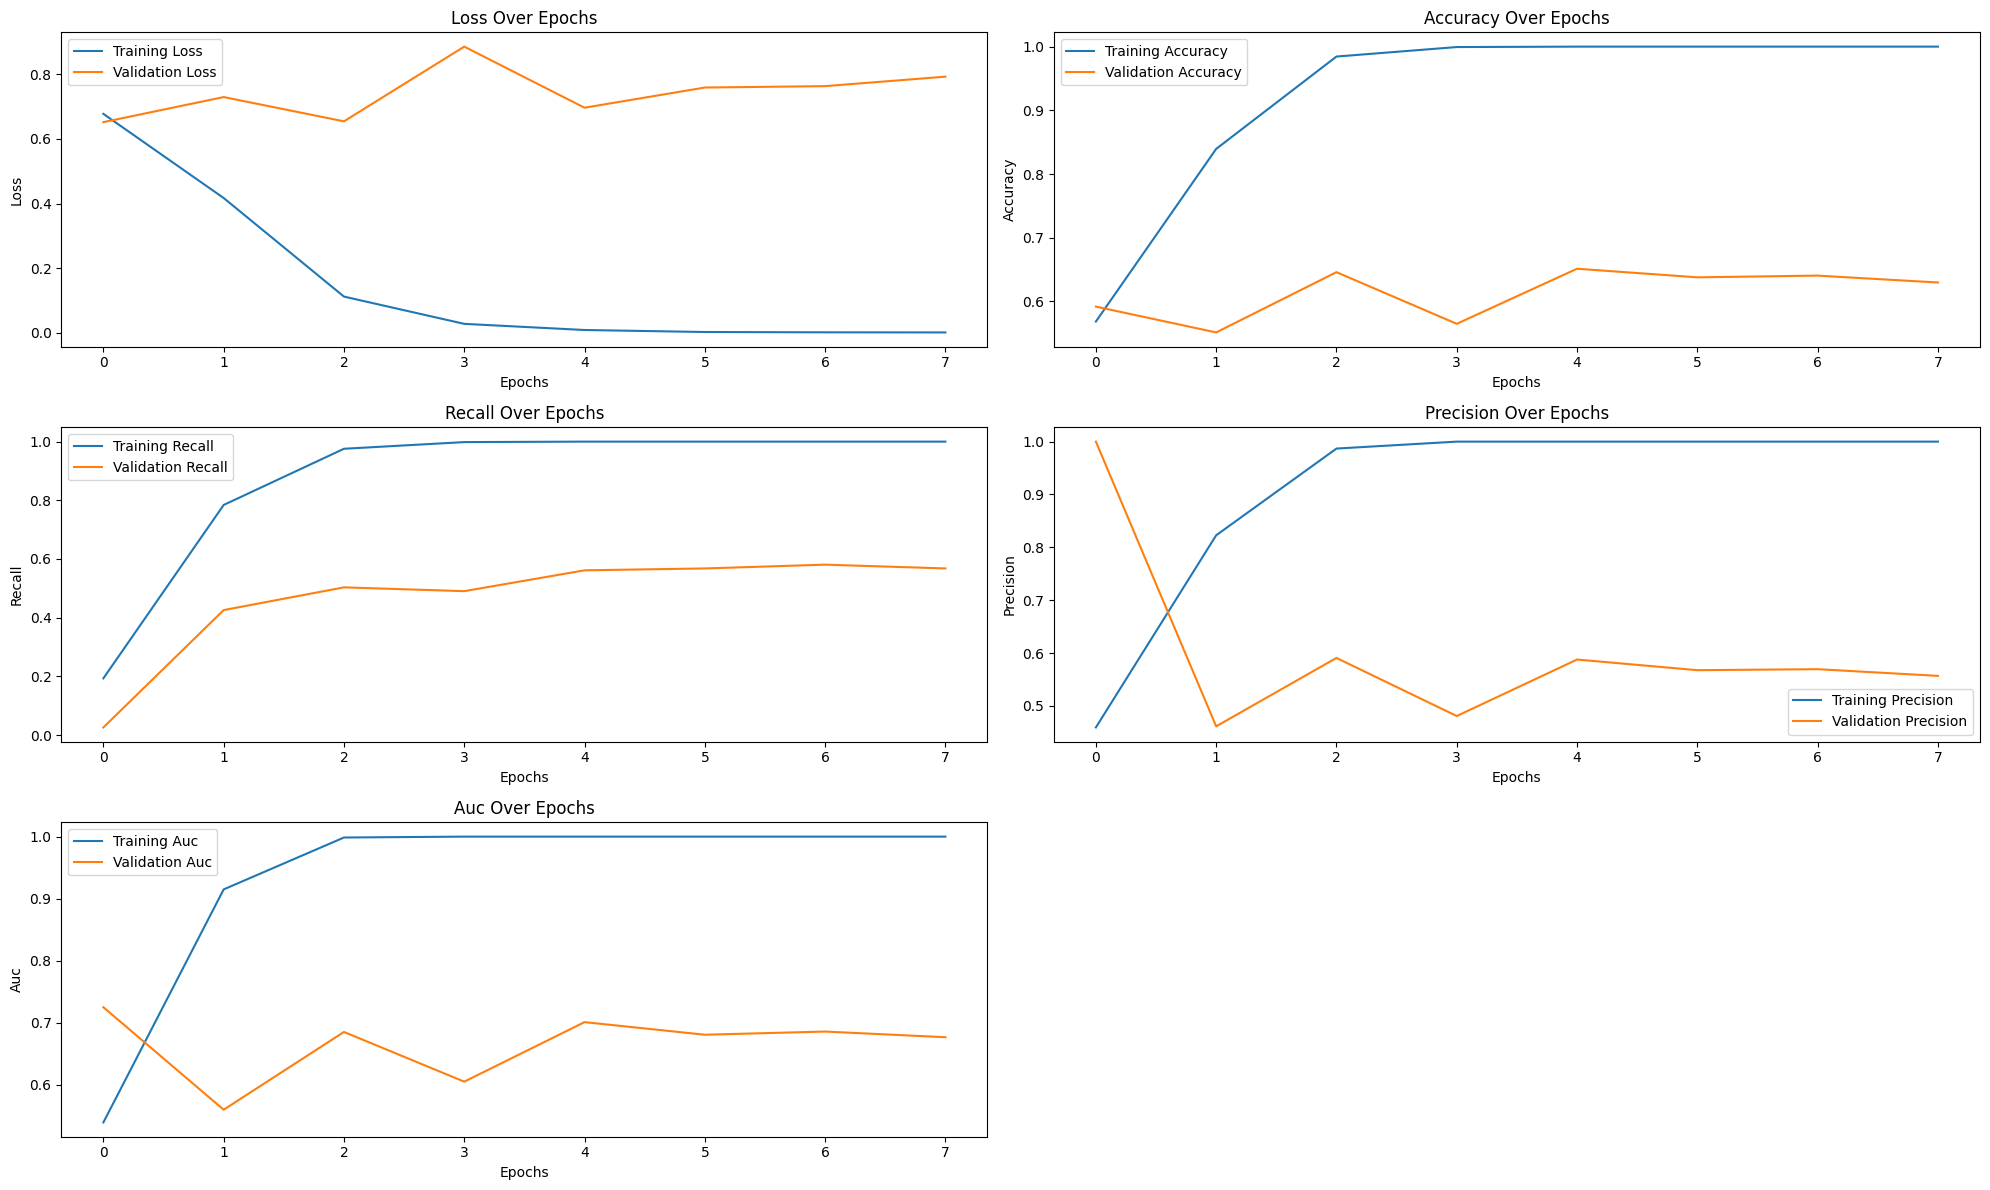


Final Training Loss: 0.0009
Final Validation Loss: 0.7929

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.6297

Final Training Recall: 1.0000
Final Validation Recall: 0.5677

Final Training Precision: 1.0000
Final Validation Precision: 0.5570

Final Training Auc: 1.0000
Final Validation Auc: 0.6766


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - AUC: 0.6537 - accuracy: 0.6097 - loss: 0.7561 - precision: 0.5422 - recall: 0.4763
{'AUC': 0.6367567181587219, 'accuracy': 0.5909090638160706, 'loss': 0.7827199101448059, 'precision': 0.5105262994766235, 'recall': 0.5025906562805176}
Test Loss: 0.7827199101448059
Test Accuracy: 0.5909090638160706
Test Recall: 0.5025906562805176
Test Precision: 0.5105262994766235
Test Auc: 0.6367567181587219


In [24]:
model_rnn_2 = deep_learning_utils.create_rnn_model(vectorize_layer=vectorize_layer,
                                                    embedding_dim=200,
                                                    rnn_units=128,
                                                    num_rnn_layers=1,
                                                    num_classes=1,
                                                    seed=seed,
                                                    dropout_rate=0,
                                                    l2_lambda=0,
                                                    metrics = metrics)

model_description = 'One Layer RNN (128), No Regularisation, Embeddings size: 200, RNN units: 128'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_rnn_2,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### Single Layer RNN with Regularisation (Dropout + L2)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_2        │ (None, 32)        │      7,456 │ embedding_2[0][0… │
│ (SimpleRNN)         │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ simple_rnn_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,342,489 (16.57 MB)

 Trainable params: 4,342,489 (16.57 MB)

 Non-trainable params: 0 (0.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 326ms/step - AUC: 0.5449 - accuracy: 0.5699 - loss: 0.9465 - precision: 0.4564 - recall: 0.2150 - val_AUC: 0.8536 - val_accuracy: 0.8054 - val_loss: 0.7459 - val_precision: 0.8320 - val_recall: 0.6710
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 333ms/step - AUC: 0.9849 - accuracy: 0.9506 - loss: 0.5200 - precision: 0.9871 - recall: 0.8921 - val_AUC: 0.8384 - val_accuracy: 0.7757 - val_loss: 0.7225 - val_precision: 0.7250 - val_recall: 0.7484
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 283ms/step - AUC: 0.9998 - accuracy: 0.9929 - loss: 0.3001 - precision: 0.9921 - recall: 0.9908 - val_AUC: 0.8105 - val_accuracy: 0.7595 - val_loss: 0.7271 - val_precision: 0.6875 - val_recall: 0.7806
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.2136 - precision: 1.0000 - recall: 1.0000 - val_AUC: 0.8825 - val_accuracy: 0.8378 - val_loss: 0.5810 - val_precision: 0.7914 - val_recal

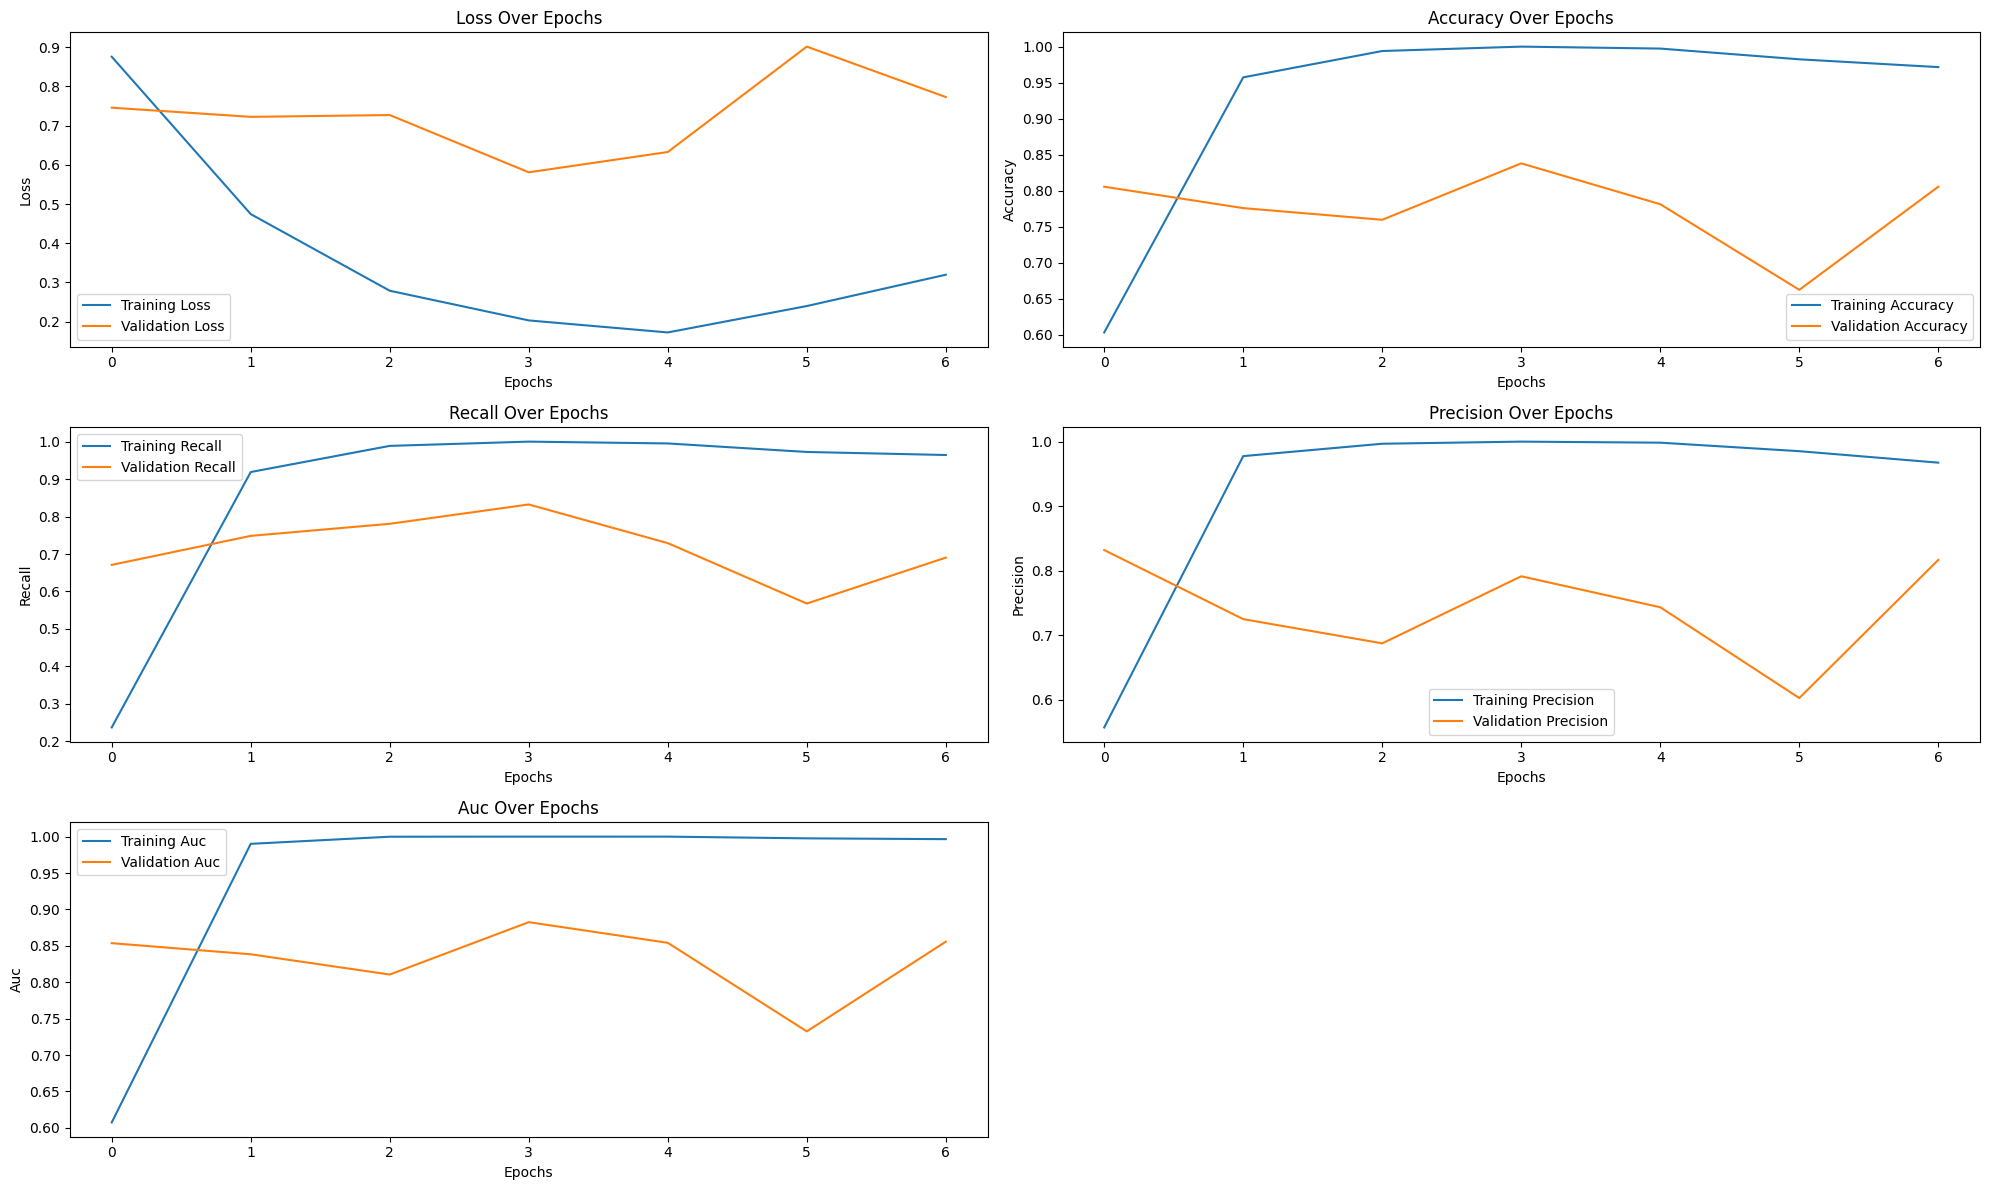


Final Training Loss: 0.3198
Final Validation Loss: 0.7730

Final Training Accuracy: 0.9715
Final Validation Accuracy: 0.8054

Final Training Recall: 0.9643
Final Validation Recall: 0.6903

Final Training Precision: 0.9674
Final Validation Precision: 0.8168

Final Training Auc: 0.9965
Final Validation Auc: 0.8557


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - AUC: 0.9104 - accuracy: 0.8646 - loss: 0.5250 - precision: 0.8250 - recall: 0.8574
{'AUC': 0.9017758965492249, 'accuracy': 0.8571428656578064, 'loss': 0.5369167923927307, 'precision': 0.8190954923629761, 'recall': 0.8445596098899841}
Test Loss: 0.5369167923927307
Test Accuracy: 0.8571428656578064
Test Recall: 0.8445596098899841
Test Precision: 0.8190954923629761
Test Auc: 0.9017758965492249


In [25]:
model_rnn_1_reg = deep_learning_utils.create_rnn_model(vectorize_layer=vectorize_layer,
                               embedding_dim=200,
                               rnn_units=32,
                               num_rnn_layers=1,
                               num_classes=1,
                               seed=seed,
                               dropout_rate=0.3,
                               l2_lambda=0.001,
                               metrics = metrics)

model_rnn_1_reg.summary()

model_description = 'One Layer RNN (32), Regularisation, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_rnn_1_reg,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### One Layer RNN, Regularisation - BatchNormalisation + Dropout

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_3        │ (None, 32)        │      7,456 │ embedding_3[0][0… │
│ (SimpleRNN)         │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ simple_rnn_3[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,342,617 (16.57 MB)

 Trainable params: 4,342,553 (16.57 MB)

 Non-trainable params: 64 (256.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - AUC: 0.5902 - accuracy: 0.5641 - loss: 1.1182 - precision: 0.4749 - recall: 0.5717 - val_AUC: 0.7836 - val_accuracy: 0.4324 - val_loss: 0.9428 - val_precision: 0.4242 - val_recall: 0.9935
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - AUC: 0.9830 - accuracy: 0.9255 - loss: 0.4482 - precision: 0.8666 - recall: 0.9688 - val_AUC: 0.7787 - val_accuracy: 0.7135 - val_loss: 0.8482 - val_precision: 0.6992 - val_recall: 0.5548
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - AUC: 0.9993 - accuracy: 0.9875 - loss: 0.2811 - precision: 0.9810 - recall: 0.9889 - val_AUC: 0.8000 - val_accuracy: 0.6865 - val_loss: 0.7990 - val_precision: 0.7910 - val_recall: 0.3419
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - AUC: 0.9999 - accuracy: 0.9947 - loss: 0.2334 - precision: 0.9886 - recall: 0.9986 - val_AUC: 0.8073 - val_accuracy: 0.6973 - val_loss: 0.7615 - val_precision: 0.7792 - val_recall: 

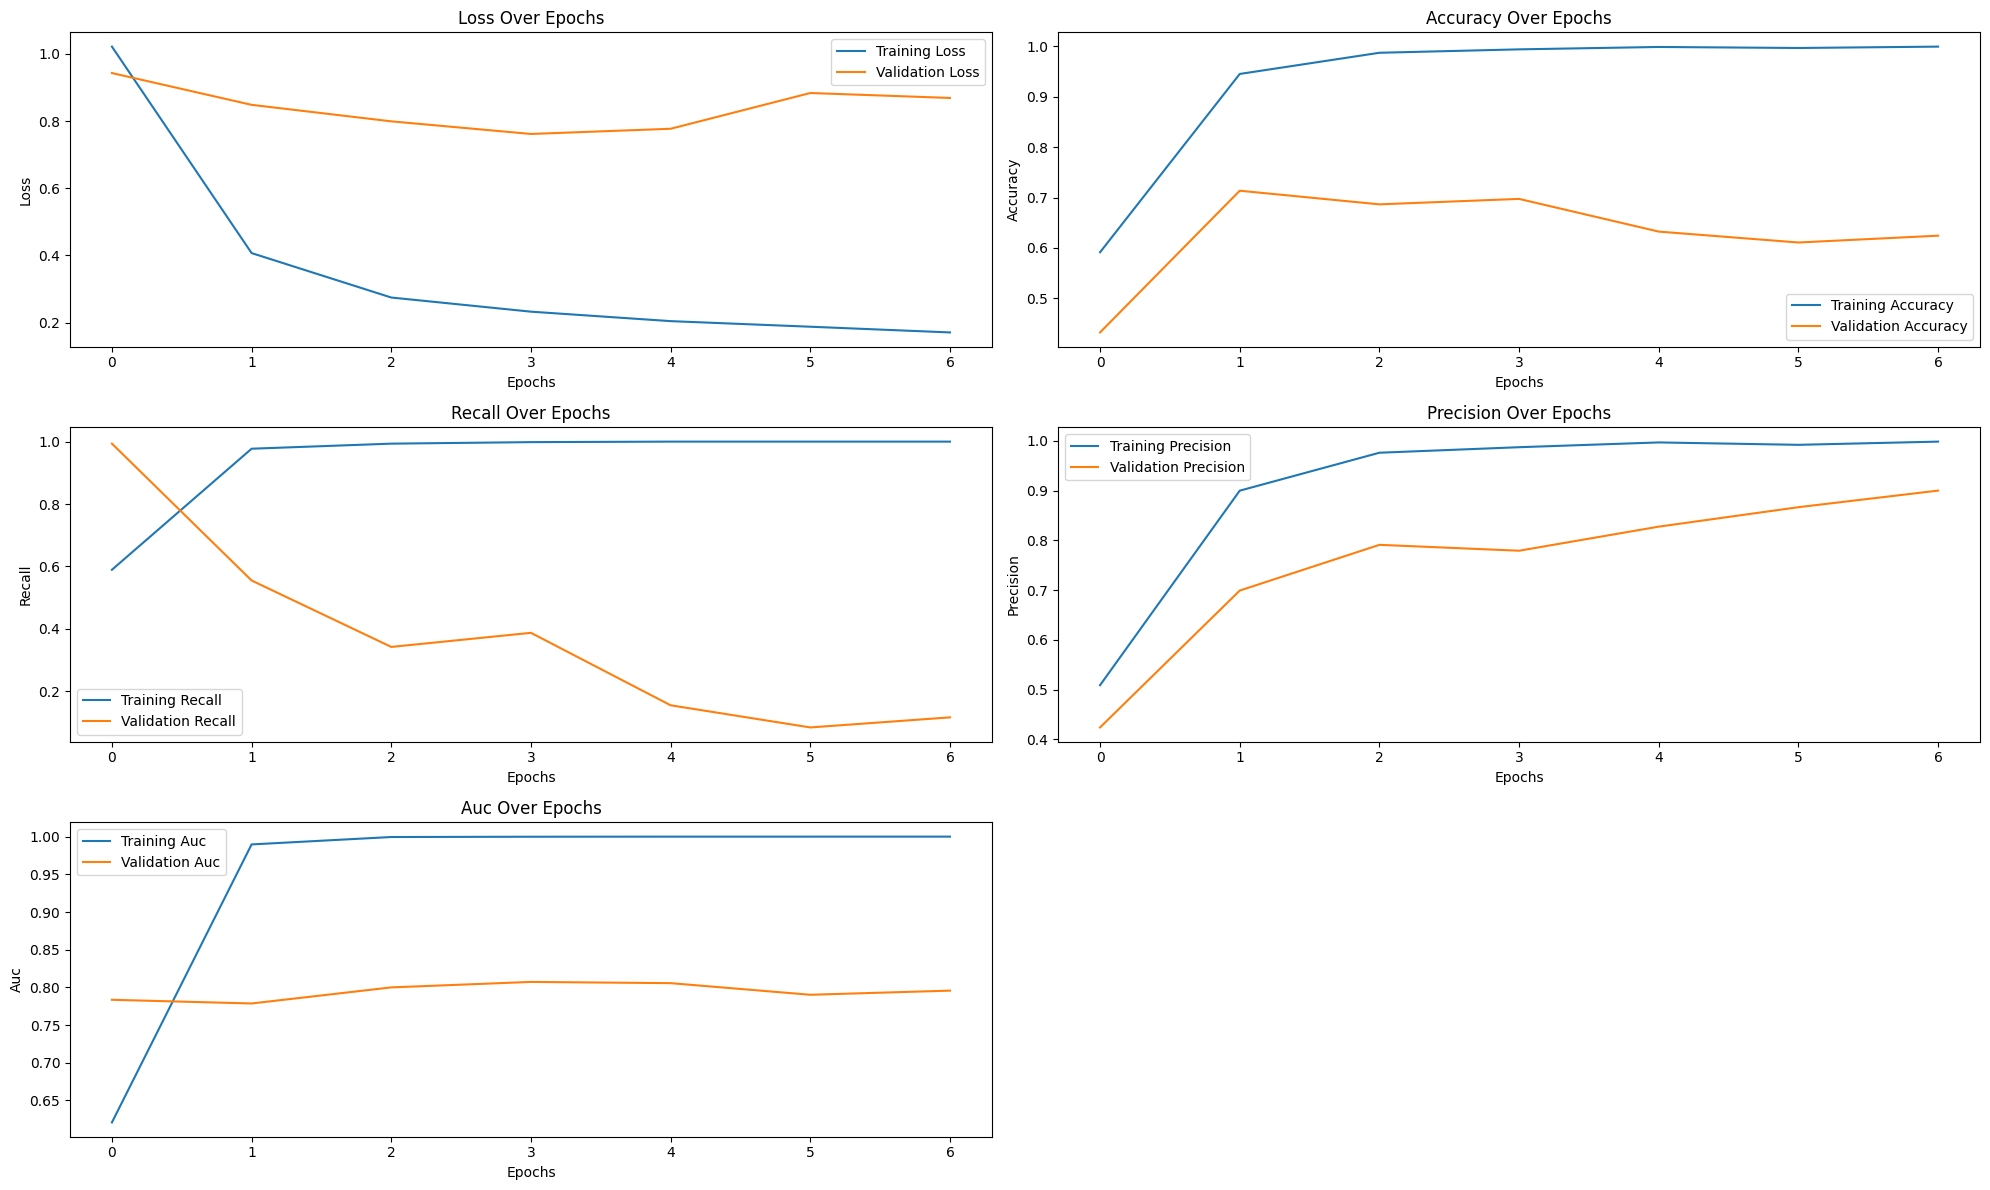


Final Training Loss: 0.1706
Final Validation Loss: 0.8687

Final Training Accuracy: 0.9993
Final Validation Accuracy: 0.6243

Final Training Recall: 1.0000
Final Validation Recall: 0.1161

Final Training Precision: 0.9984
Final Validation Precision: 0.9000

Final Training Auc: 1.0000
Final Validation Auc: 0.7957


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.7596 - accuracy: 0.6865 - loss: 0.7856 - precision: 0.7190 - recall: 0.4000
{'AUC': 0.7713080644607544, 'accuracy': 0.6904761791229248, 'loss': 0.7822411060333252, 'precision': 0.7450980544090271, 'recall': 0.393782377243042}
Test Loss: 0.7822411060333252
Test Accuracy: 0.6904761791229248
Test Recall: 0.393782377243042
Test Precision: 0.7450980544090271
Test Auc: 0.7713080644607544


In [26]:

model_rnn_1_reg_bn = deep_learning_utils.create_rnn_model(vectorize_layer=vectorize_layer,
                                 embedding_dim=200,
                                 rnn_units=32,
                                 num_rnn_layers=1,
                                 num_classes=1,
                                 seed=seed,
                                 dropout_rate=0.3,
                                 l2_lambda=0.001,
                                 metrics = metrics,
                                 batch_normalization=True)

model_rnn_1_reg_bn.summary()

model_description = 'One Layer RNN (32), Regularisation, Batch Normalization, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_rnn_1_reg_bn,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### Two-Layers RNN, No Regularisation

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_4        │ (None, 256, 32)   │      7,456 │ embedding_4[0][0… │
│ (SimpleRNN)         │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256, 32)   │          0 │ simple_rnn_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_5        │ (None, 32)        │      2,080 │ dropout_4[0][0],  │
│ (SimpleRNN)         │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ simple_rnn_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,344,569 (16.57 MB)

 Trainable params: 4,344,569 (16.57 MB)

 Non-trainable params: 0 (0.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - AUC: 0.6440 - accuracy: 0.6405 - loss: 0.6264 - precision: 0.5913 - recall: 0.3225 - val_AUC: 0.8541 - val_accuracy: 0.8297 - val_loss: 0.4435 - val_precision: 0.7584 - val_recall: 0.8710
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - AUC: 0.9973 - accuracy: 0.9661 - loss: 0.1356 - precision: 0.9630 - recall: 0.9537 - val_AUC: 0.8456 - val_accuracy: 0.8027 - val_loss: 0.4958 - val_precision: 0.7412 - val_recall: 0.8129
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.0103 - precision: 1.0000 - recall: 1.0000 - val_AUC: 0.7731 - val_accuracy: 0.7189 - val_loss: 0.6384 - val_precision: 0.6624 - val_recall: 0.6710
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.0039 - precision: 1.0000 - recall: 1.0000 - val_AUC: 0.7694 - val_accuracy: 0.7189 - val_loss: 0.6602 - val_precision: 0.6604 - val_recall:

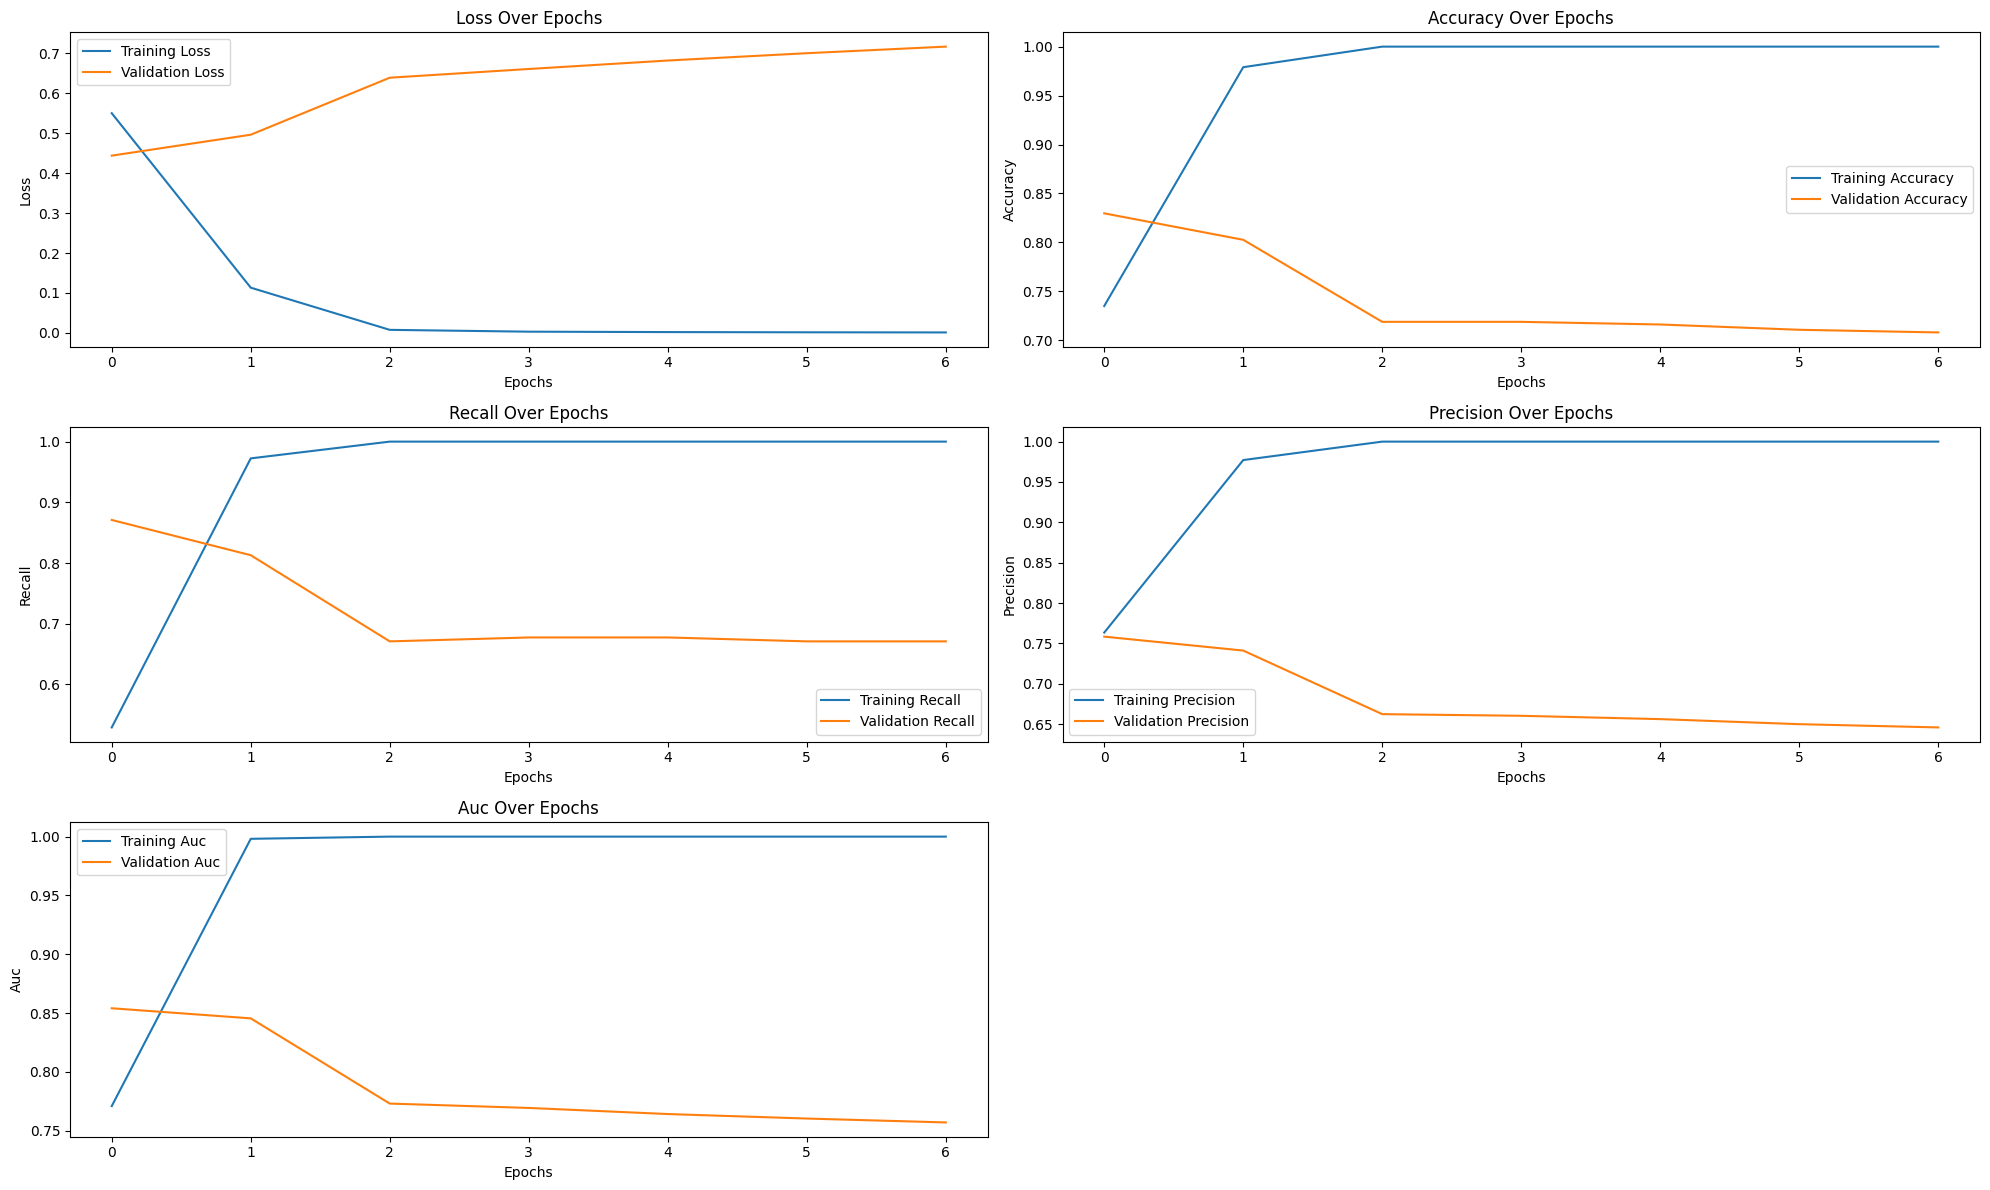


Final Training Loss: 0.0014
Final Validation Loss: 0.7161

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.7081

Final Training Recall: 1.0000
Final Validation Recall: 0.6710

Final Training Precision: 1.0000
Final Validation Precision: 0.6460

Final Training Auc: 1.0000
Final Validation Auc: 0.7571


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - AUC: 0.8091 - accuracy: 0.7426 - loss: 0.5867 - precision: 0.6619 - recall: 0.7890
{'AUC': 0.8125662207603455, 'accuracy': 0.7532467246055603, 'loss': 0.5748891830444336, 'precision': 0.6803653240203857, 'recall': 0.772020697593689}
Test Loss: 0.5748891830444336
Test Accuracy: 0.7532467246055603
Test Recall: 0.772020697593689
Test Precision: 0.6803653240203857
Test Auc: 0.8125662207603455


In [27]:

model_rnn_2 = deep_learning_utils.create_rnn_model(vectorize_layer=vectorize_layer,
                                 embedding_dim=200,
                                 rnn_units=32,
                                 num_rnn_layers=2,
                                 num_classes=1,
                                 seed=seed,
                                 dropout_rate=0,
                                 l2_lambda=0,
                                 metrics = metrics)

model_rnn_2.summary()

model_description = 'Two Layer RNN (32), No Regularisation, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_rnn_2,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### Two-Layers RNN, With Regularisation

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_6        │ (None, 256, 32)   │      7,456 │ embedding_5[0][0… │
│ (SimpleRNN)         │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256, 32)   │          0 │ simple_rnn_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_7        │ (None, 32)        │      2,080 │ dropout_6[0][0],  │
│ (SimpleRNN)         │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ simple_rnn_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,344,569 (16.57 MB)

 Trainable params: 4,344,569 (16.57 MB)

 Non-trainable params: 0 (0.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - AUC: 0.5875 - accuracy: 0.5797 - loss: 1.0384 - precision: 0.4995 - recall: 0.5114 - val_AUC: 0.5436 - val_accuracy: 0.6216 - val_loss: 0.9578 - val_precision: 0.8571 - val_recall: 0.1161
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - AUC: 0.9607 - accuracy: 0.8834 - loss: 0.6750 - precision: 0.8502 - recall: 0.8686 - val_AUC: 0.6666 - val_accuracy: 0.6405 - val_loss: 1.0053 - val_precision: 0.6038 - val_recall: 0.4129
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - AUC: 1.0000 - accuracy: 0.9961 - loss: 0.4179 - precision: 1.0000 - recall: 0.9905 - val_AUC: 0.6703 - val_accuracy: 0.6378 - val_loss: 1.0516 - val_precision: 0.5636 - val_recall: 0.6000
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.3217 - precision: 1.0000 - recall: 1.0000 - val_AUC: 0.6847 - val_accuracy: 0.6432 - val_loss: 1.0088 - val_precision: 0.5742 - val_recal

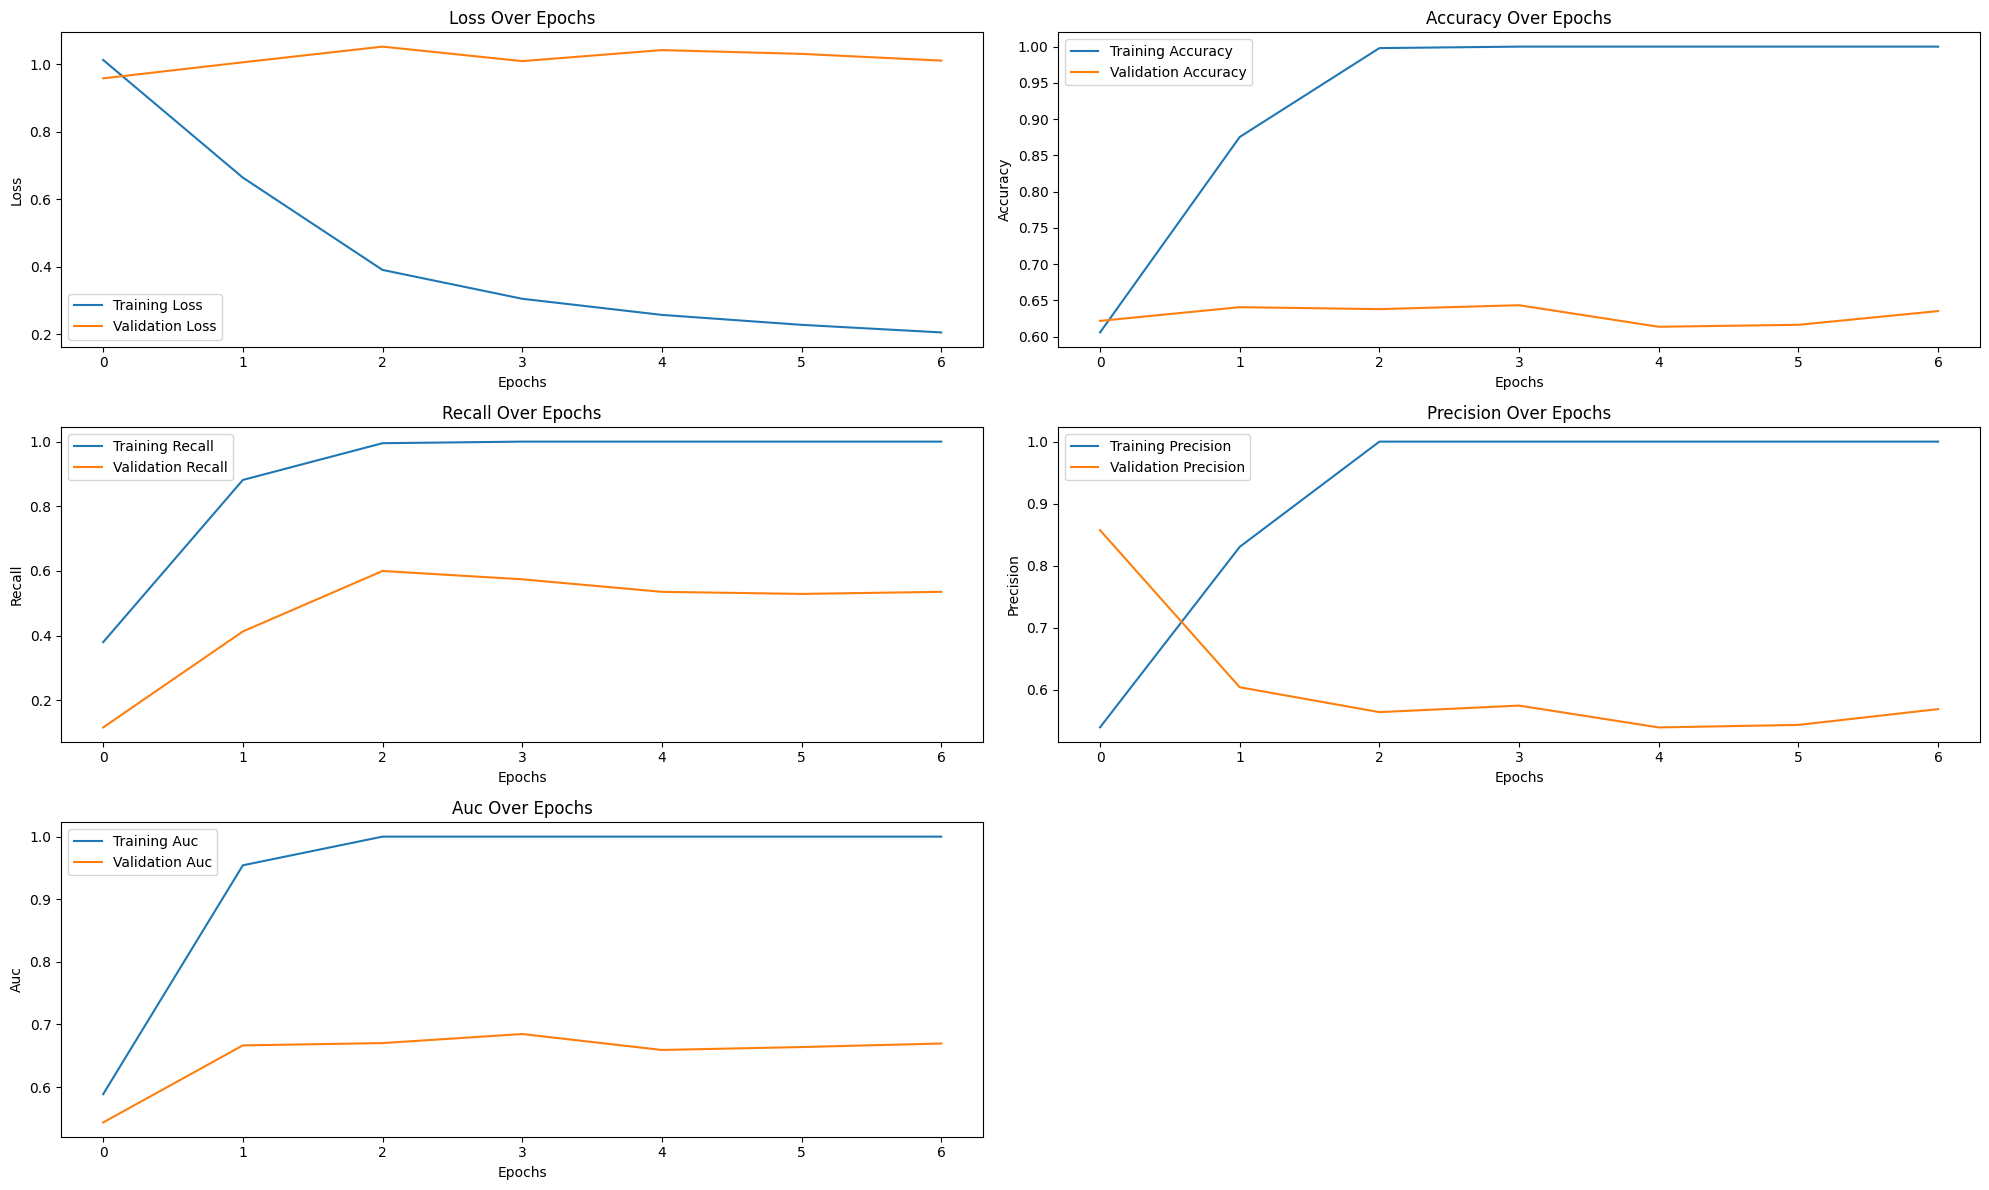


Final Training Loss: 0.2058
Final Validation Loss: 1.0103

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.6351

Final Training Recall: 1.0000
Final Validation Recall: 0.5355

Final Training Precision: 1.0000
Final Validation Precision: 0.5685

Final Training Auc: 1.0000
Final Validation Auc: 0.6696


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - AUC: 0.6856 - accuracy: 0.6415 - loss: 0.9854 - precision: 0.5713 - recall: 0.6029
{'AUC': 0.7099601626396179, 'accuracy': 0.673160195350647, 'loss': 0.9755025506019592, 'precision': 0.6082473993301392, 'recall': 0.6113989353179932}
Test Loss: 0.9755025506019592
Test Accuracy: 0.673160195350647
Test Recall: 0.6113989353179932
Test Precision: 0.6082473993301392
Test Auc: 0.7099601626396179


In [28]:
# two layers rnn with regularization

model_rnn_2_reg = deep_learning_utils.create_rnn_model(vectorize_layer=vectorize_layer,
                                    embedding_dim=200,
                                    rnn_units=32,
                                    num_rnn_layers=2,
                                    num_classes=1,
                                    seed=seed,
                                    dropout_rate=0.3,
                                    l2_lambda=0.001,
                                    metrics = metrics)

model_rnn_2_reg.summary()

model_description = 'Two Layer RNN (32), Regularisation, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_rnn_2_reg,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )


### Two-Layer RNN with Regularisation BatchNorm + Dropout

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_8        │ (None, 256, 32)   │      7,456 │ embedding_6[0][0… │
│ (SimpleRNN)         │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ simple_rnn_8[0][… │
│ (BatchNormalizatio… │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_9        │ (None, 32)        │      2,080 │ dropout_8[0][0],  │
│ (SimpleRNN)         │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ simple_rnn_9[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         33 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,344,825 (16.57 MB)

 Trainable params: 4,344,697 (16.57 MB)

 Non-trainable params: 128 (512.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 345ms/step - AUC: 0.5194 - accuracy: 0.5266 - loss: 1.3822 - precision: 0.4358 - recall: 0.5167 - val_AUC: 0.5731 - val_accuracy: 0.5892 - val_loss: 1.0292 - val_precision: 0.7143 - val_recall: 0.0323
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - AUC: 0.9027 - accuracy: 0.8261 - loss: 0.7542 - precision: 0.7773 - recall: 0.8085 - val_AUC: 0.6947 - val_accuracy: 0.6865 - val_loss: 0.9960 - val_precision: 0.7097 - val_recall: 0.4258
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - AUC: 0.9851 - accuracy: 0.9298 - loss: 0.5480 - precision: 0.8845 - recall: 0.9548 - val_AUC: 0.7115 - val_accuracy: 0.6514 - val_loss: 0.9718 - val_precision: 0.5802 - val_recall: 0.6065
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - AUC: 0.9964 - accuracy: 0.9712 - loss: 0.4396 - precision: 0.9501 - recall: 0.9815 - val_AUC: 0.7895 - val_accuracy: 0.7216 - val_loss: 0.8885 - val_precision: 0.6970 - val_recal

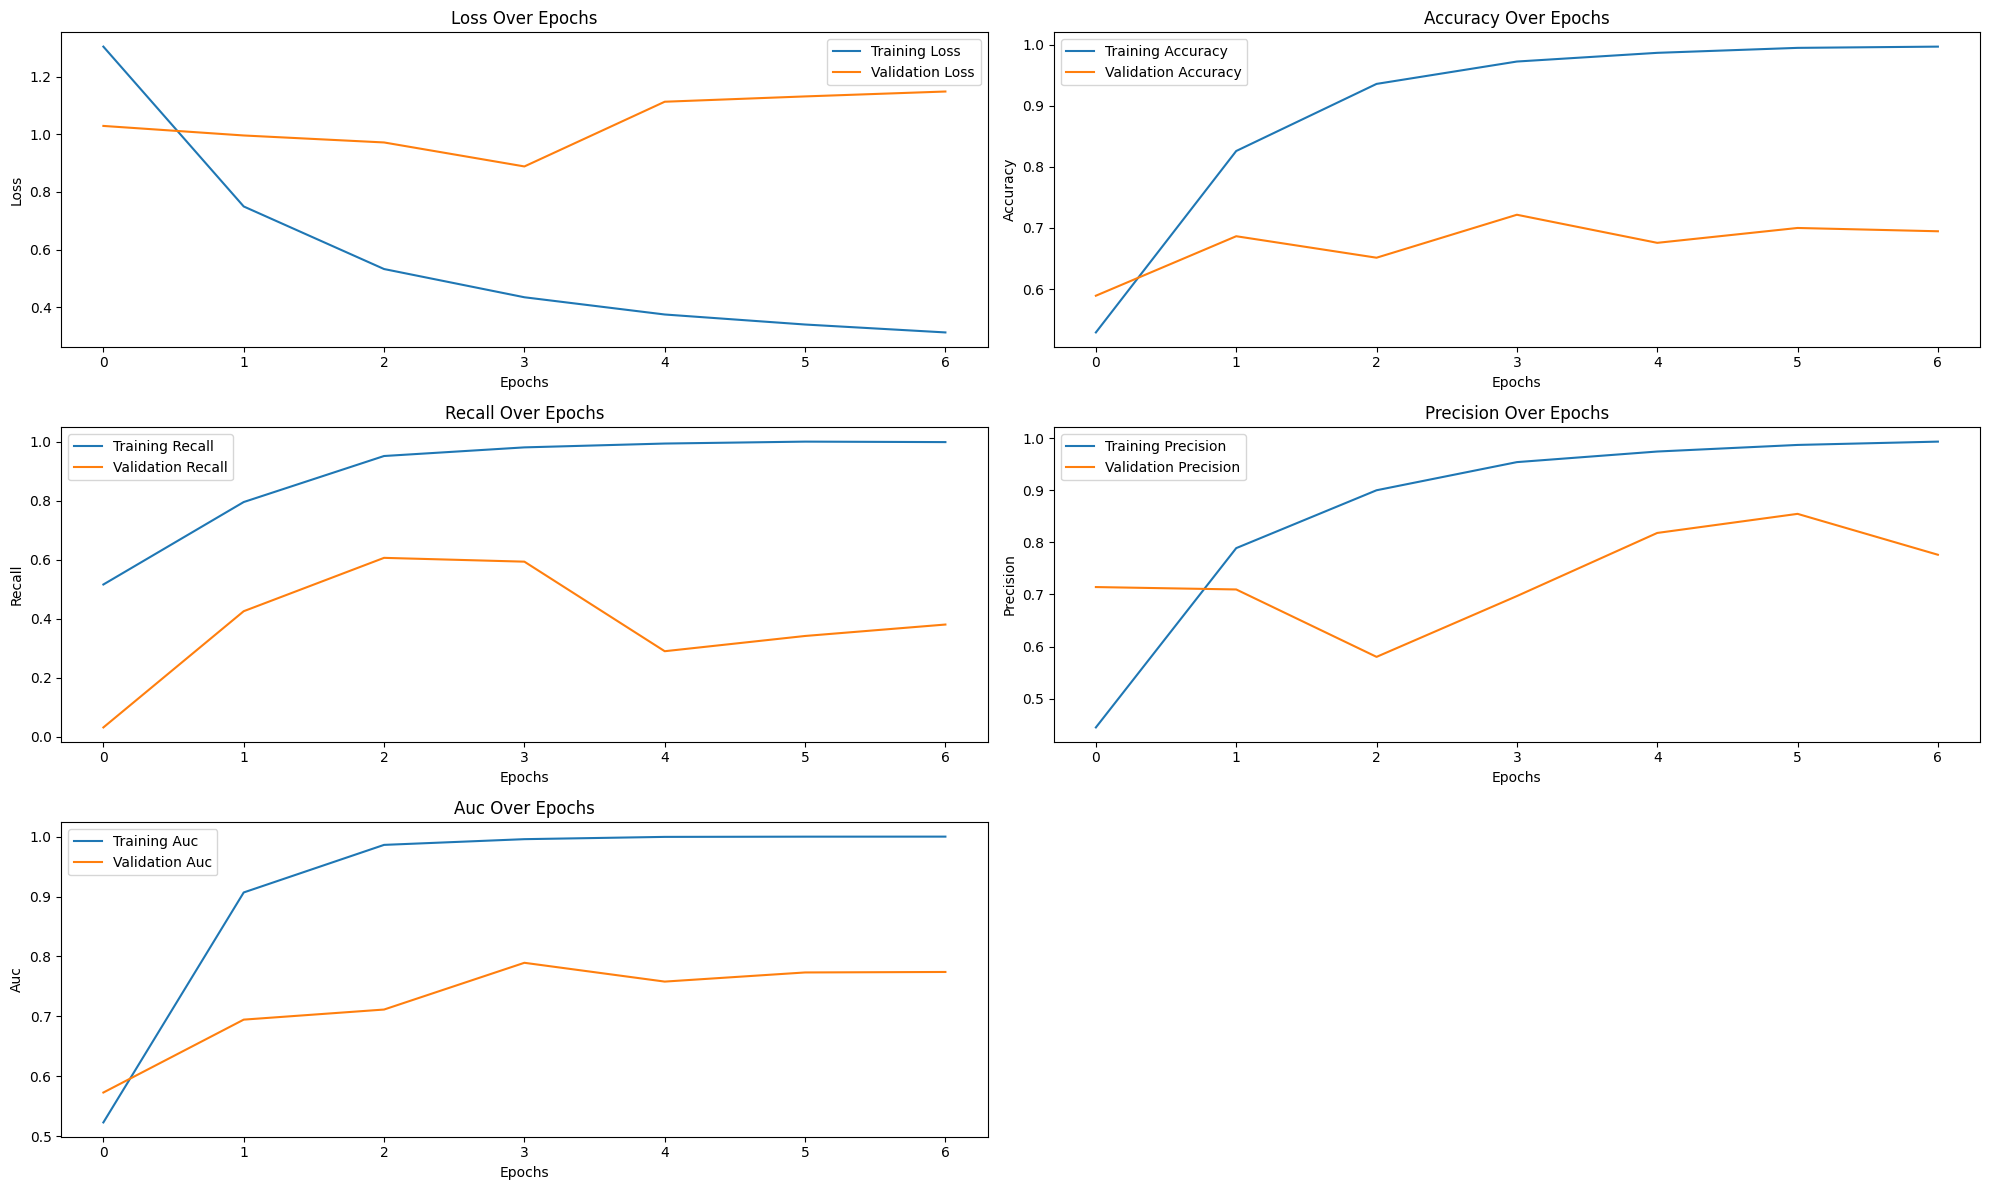


Final Training Loss: 0.3121
Final Validation Loss: 1.1487

Final Training Accuracy: 0.9966
Final Validation Accuracy: 0.6946

Final Training Recall: 0.9984
Final Validation Recall: 0.3806

Final Training Precision: 0.9935
Final Validation Precision: 0.7763

Final Training Auc: 0.9999
Final Validation Auc: 0.7742


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - AUC: 0.8199 - accuracy: 0.7591 - loss: 0.8511 - precision: 0.7481 - recall: 0.6329
{'AUC': 0.8073945045471191, 'accuracy': 0.7359307408332825, 'loss': 0.8662327527999878, 'precision': 0.7261146306991577, 'recall': 0.590673565864563}
Test Loss: 0.8662327527999878
Test Accuracy: 0.7359307408332825
Test Recall: 0.590673565864563
Test Precision: 0.7261146306991577
Test Auc: 0.8073945045471191


In [29]:
### Two-Layer RNN with Regularisation BatchNorm + Dropout

model_rnn_2_reg_bn = deep_learning_utils.create_rnn_model(vectorize_layer=vectorize_layer,
                                        embedding_dim=200,
                                        rnn_units=32,
                                        num_rnn_layers=2,
                                        num_classes=1,
                                        seed=seed,
                                        dropout_rate=0.3,
                                        l2_lambda=0.001,
                                        metrics = metrics,
                                        batch_normalization=True)

model_rnn_2_reg_bn.summary()

model_description = 'Two Layer RNN (32), Regularisation, Batch Normalization, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_rnn_2_reg_bn,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

In [30]:
model_registry

,n_epochs,avg_epoch_time,test_loss,test_accuracy,test_recall,test_precision,test_AUC,model,training_time
0,7,4.611504,0.512451,0.746753,0.663212,0.711111,0.821272,NaN,NaN
1,8,6.875523,0.782720,0.590909,0.502591,0.510526,0.636757,NaN,NaN
2,7,6.412905,0.536917,0.857143,0.844560,0.819095,0.901776,NaN,NaN
3,7,5.673068,0.782241,0.690476,0.393782,0.745098,0.771308,NaN,NaN
4,7,7.542915,0.574889,0.753247,0.772021,0.680365,0.812566,NaN,NaN
5,7,10.359922,0.975503,0.673160,0.611399,0.608247,0.709960,NaN,NaN
6,7,9.256730,0.866233,0.735931,0.590674,0.726115,0.807395,NaN,NaN
7,7,7.036167,0.460066,0.844156,0.813471,0.813471,0.900428,NaN,NaN
8,7,8.856632,0.583468,0.818182,0.756477,0.797814,0.897904,NaN,NaN
9,8,8.327646,0.509490,0.800866,0.735751,0.775956,0.893936,NaN,NaN


## LSTM Models

### Single Layer LSTM, No Regularisation

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 32)        │     29,824 │ embedding_7[0][0… │
│                     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 32)        │          0 │ lstm[0][0]        │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         33 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,364,857 (16.65 MB)

 Trainable params: 4,364,857 (16.65 MB)

 Non-trainable params: 0 (0.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - AUC: 0.6527 - accuracy: 0.6137 - loss: 0.6529 - precision: 0.6459 - recall: 0.1399 - val_AUC: 0.8974 - val_accuracy: 0.8405 - val_loss: 0.4116 - val_precision: 0.7927 - val_recall: 0.8387
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - AUC: 0.9688 - accuracy: 0.9009 - loss: 0.2627 - precision: 0.8822 - recall: 0.8754 - val_AUC: 0.8980 - val_accuracy: 0.8135 - val_loss: 0.4132 - val_precision: 0.7363 - val_recall: 0.8645
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - AUC: 0.9958 - accuracy: 0.9722 - loss: 0.1287 - precision: 0.9411 - recall: 0.9948 - val_AUC: 0.8911 - val_accuracy: 0.8216 - val_loss: 0.5134 - val_precision: 0.8296 - val_recall: 0.7226
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - AUC: 0.9977 - accuracy: 0.9906 - loss: 0.0472 - precision: 0.9884 - recall: 0.9889 - val_AUC: 0.8790 - val_accuracy: 0.8243 - val_loss: 0.5455 - val_precision: 0.7922 - val_recall:

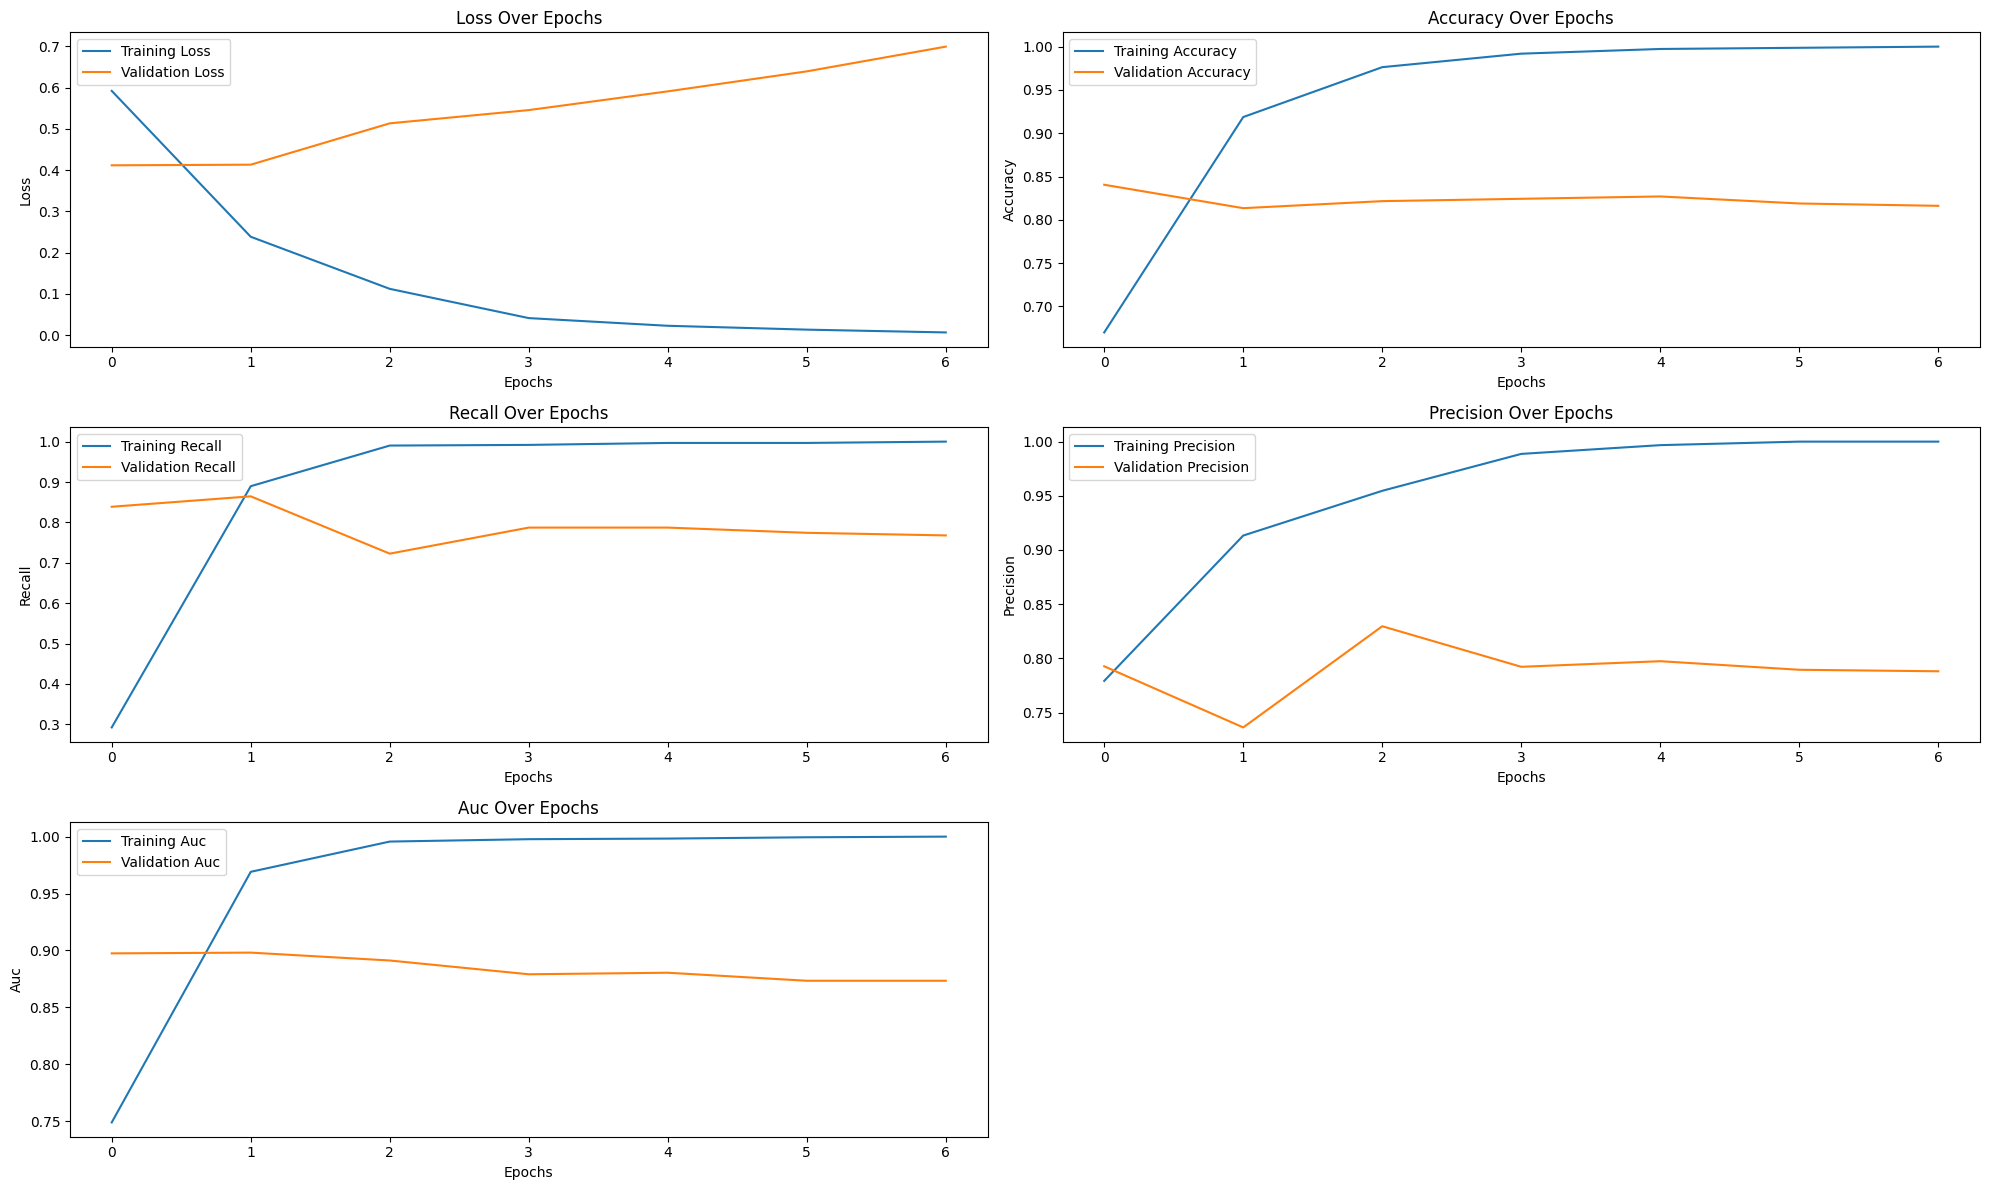


Final Training Loss: 0.0065
Final Validation Loss: 0.6994

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.8162

Final Training Recall: 1.0000
Final Validation Recall: 0.7677

Final Training Precision: 1.0000
Final Validation Precision: 0.7881

Final Training Auc: 1.0000
Final Validation Auc: 0.8733


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - AUC: 0.9051 - accuracy: 0.8448 - loss: 0.4540 - precision: 0.7983 - recall: 0.8405
{'AUC': 0.9004276394844055, 'accuracy': 0.8441558480262756, 'loss': 0.4600655138492584, 'precision': 0.8134714961051941, 'recall': 0.8134714961051941}
Test Loss: 0.4600655138492584
Test Accuracy: 0.8441558480262756
Test Recall: 0.8134714961051941
Test Precision: 0.8134714961051941
Test Auc: 0.9004276394844055


In [31]:
### Single Layer LSTM, No Regularisation

model_lstm_1 = deep_learning_utils.create_lstm_model(vectorize_layer=vectorize_layer,
                                    embedding_dim=200,
                                    lstm_units=32,
                                    num_lstm_layers=1,
                                    num_classes=1,
                                    seed=seed,
                                    dropout_rate=0,
                                    l2_lambda=0,
                                    metrics = metrics)

model_lstm_1.summary()

model_description = 'One Layer LSTM (32), No Regularisation, Embeddings size: 200'
 
model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_1,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### One Layer LSTM With Regularisation L2 + Dropout

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_8         │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     29,824 │ embedding_8[0][0… │
│                     │                   │            │ not_equal_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32)        │          0 │ lstm_1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         33 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,364,857 (16.65 MB)

 Trainable params: 4,364,857 (16.65 MB)

 Non-trainable params: 0 (0.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - AUC: 0.6126 - accuracy: 0.5910 - loss: 0.9582 - precision: 0.5362 - recall: 0.0875 - val_AUC: 0.8893 - val_accuracy: 0.8324 - val_loss: 0.5517 - val_precision: 0.8121 - val_recall: 0.7806
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - AUC: 0.9161 - accuracy: 0.8477 - loss: 0.5027 - precision: 0.7988 - recall: 0.8413 - val_AUC: 0.9112 - val_accuracy: 0.8405 - val_loss: 0.5044 - val_precision: 0.7927 - val_recall: 0.8387
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - AUC: 0.9829 - accuracy: 0.9472 - loss: 0.3241 - precision: 0.9153 - recall: 0.9605 - val_AUC: 0.8988 - val_accuracy: 0.8162 - val_loss: 0.5687 - val_precision: 0.7208 - val_recall: 0.9161
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - AUC: 0.9916 - accuracy: 0.9578 - loss: 0.2803 - precision: 0.9203 - recall: 0.9828 - val_AUC: 0.9011 - val_accuracy: 0.8432 - val_loss: 0.5793 - val_precision: 0.8255 - val_recal

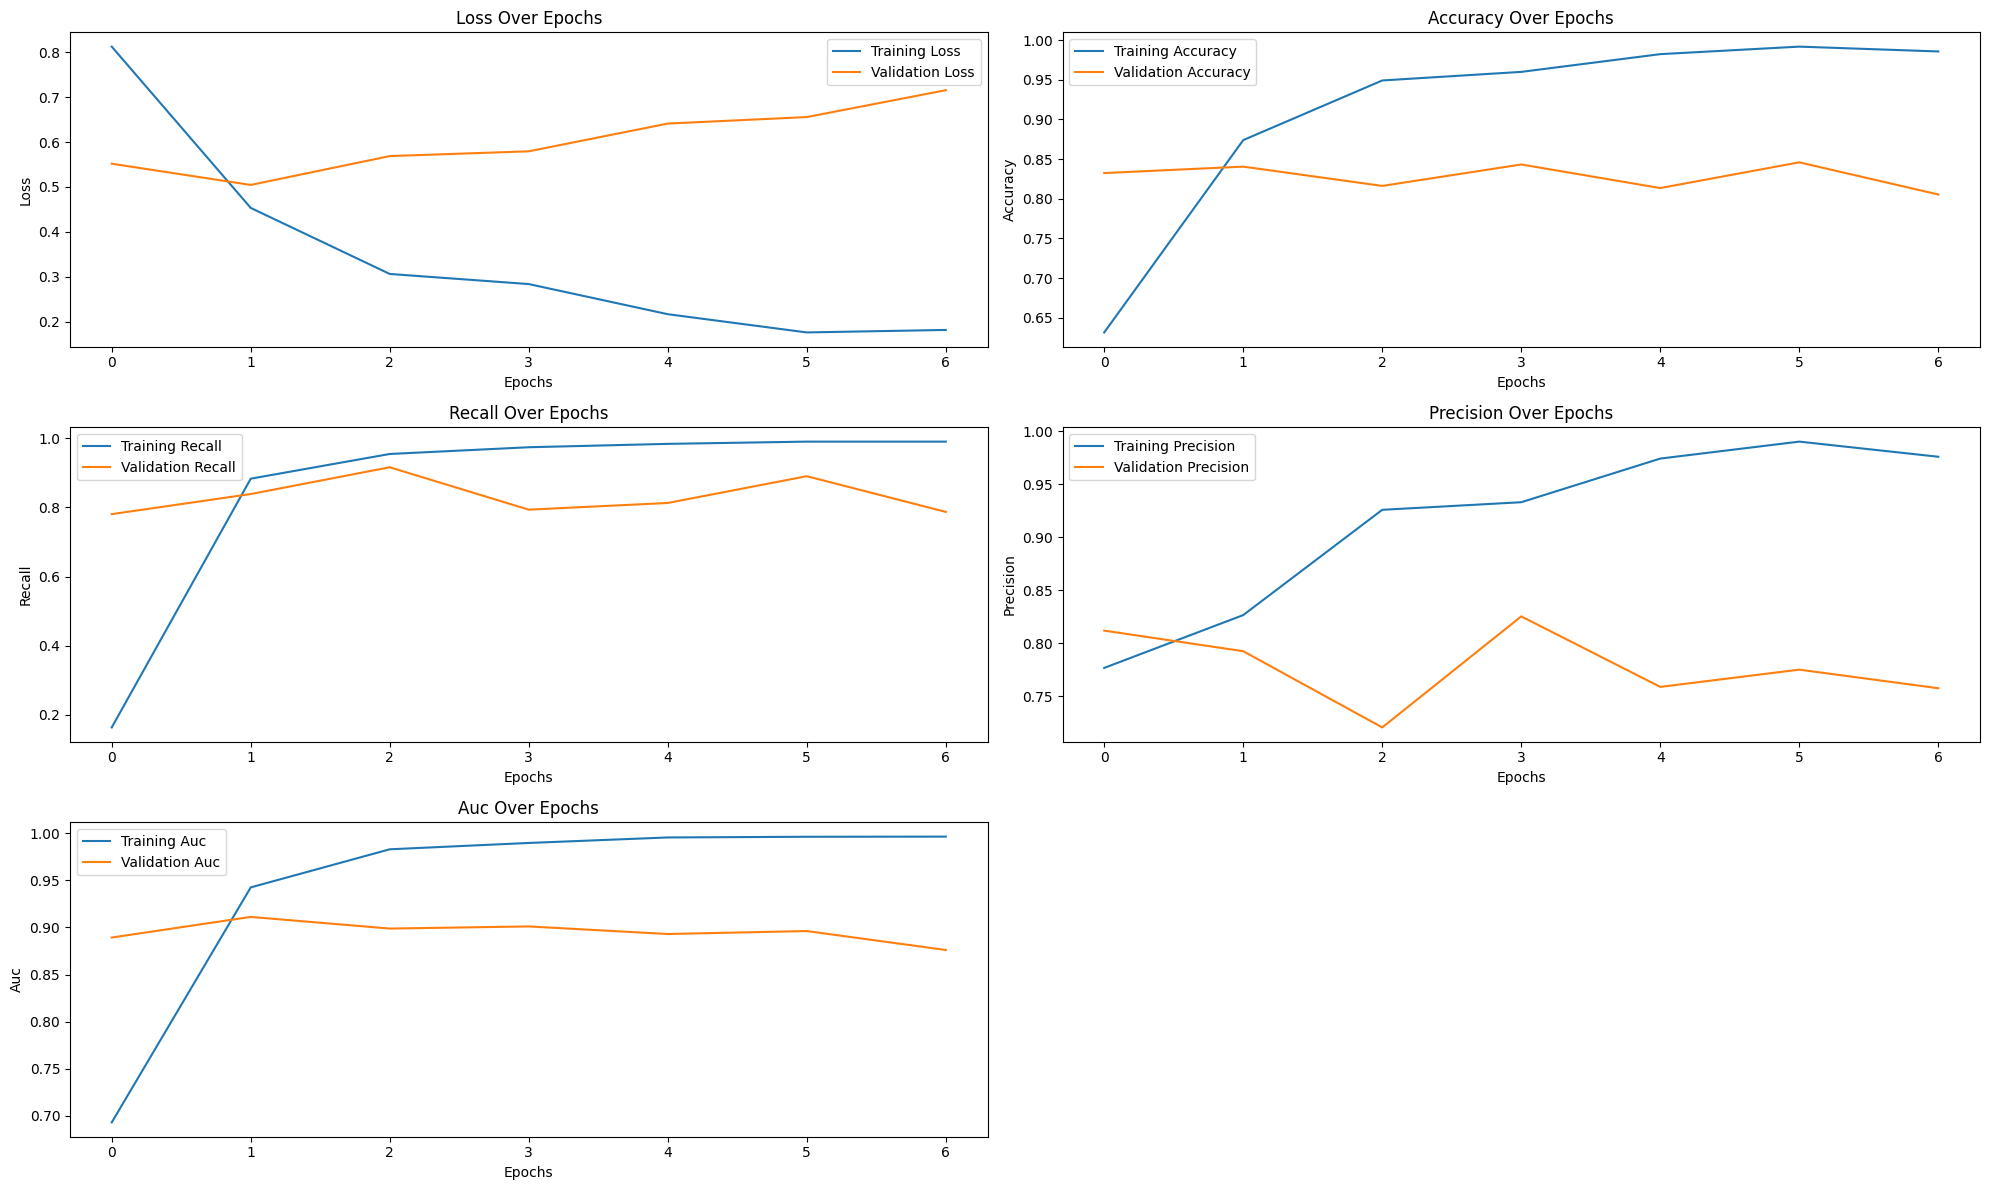


Final Training Loss: 0.1814
Final Validation Loss: 0.7154

Final Training Accuracy: 0.9858
Final Validation Accuracy: 0.8054

Final Training Recall: 0.9903
Final Validation Recall: 0.7871

Final Training Precision: 0.9760
Final Validation Precision: 0.7578

Final Training Auc: 0.9965
Final Validation Auc: 0.8761


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - AUC: 0.9086 - accuracy: 0.8203 - loss: 0.5581 - precision: 0.7948 - recall: 0.7706
{'AUC': 0.8979043364524841, 'accuracy': 0.8181818127632141, 'loss': 0.5834680199623108, 'precision': 0.7978141903877258, 'recall': 0.7564767003059387}
Test Loss: 0.5834680199623108
Test Accuracy: 0.8181818127632141
Test Recall: 0.7564767003059387
Test Precision: 0.7978141903877258
Test Auc: 0.8979043364524841


In [32]:
### One Layer LSTM With Regularisation L2 + Dropout

model_lstm_1_reg = deep_learning_utils.create_lstm_model(vectorize_layer=vectorize_layer,
                                        embedding_dim=200,
                                        lstm_units=32,
                                        num_lstm_layers=1,
                                        num_classes=1,
                                        seed=seed,
                                        dropout_rate=0.3,
                                        l2_lambda=0.001,
                                        metrics = metrics)

model_lstm_1_reg.summary()

model_description = 'One Layer LSTM (32), Regularisation, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_1_reg,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### One Layer LSTM with Regularisation - BatchNorm & Dropout

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_9         │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 32)        │     29,824 │ embedding_9[0][0… │
│                     │                   │            │ not_equal_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         33 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,364,985 (16.65 MB)

 Trainable params: 4,364,921 (16.65 MB)

 Non-trainable params: 64 (256.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 241ms/step - AUC: 0.7306 - accuracy: 0.6719 - loss: 0.9065 - precision: 0.5878 - recall: 0.6827 - val_AUC: 0.8991 - val_accuracy: 0.7243 - val_loss: 0.7890 - val_precision: 0.9077 - val_recall: 0.3806
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - AUC: 0.9863 - accuracy: 0.9516 - loss: 0.3154 - precision: 0.9297 - recall: 0.9544 - val_AUC: 0.8937 - val_accuracy: 0.8027 - val_loss: 0.6804 - val_precision: 0.8203 - val_recall: 0.6774
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - AUC: 0.9990 - accuracy: 0.9904 - loss: 0.1590 - precision: 0.9953 - recall: 0.9814 - val_AUC: 0.8771 - val_accuracy: 0.7865 - val_loss: 0.6235 - val_precision: 0.8393 - val_recall: 0.6065
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - AUC: 0.9995 - accuracy: 0.9922 - loss: 0.1322 - precision: 0.9962 - recall: 0.9850 - val_AUC: 0.8885 - val_accuracy: 0.8054 - val_loss: 0.5633 - val_precision: 0.8268 - val_recall

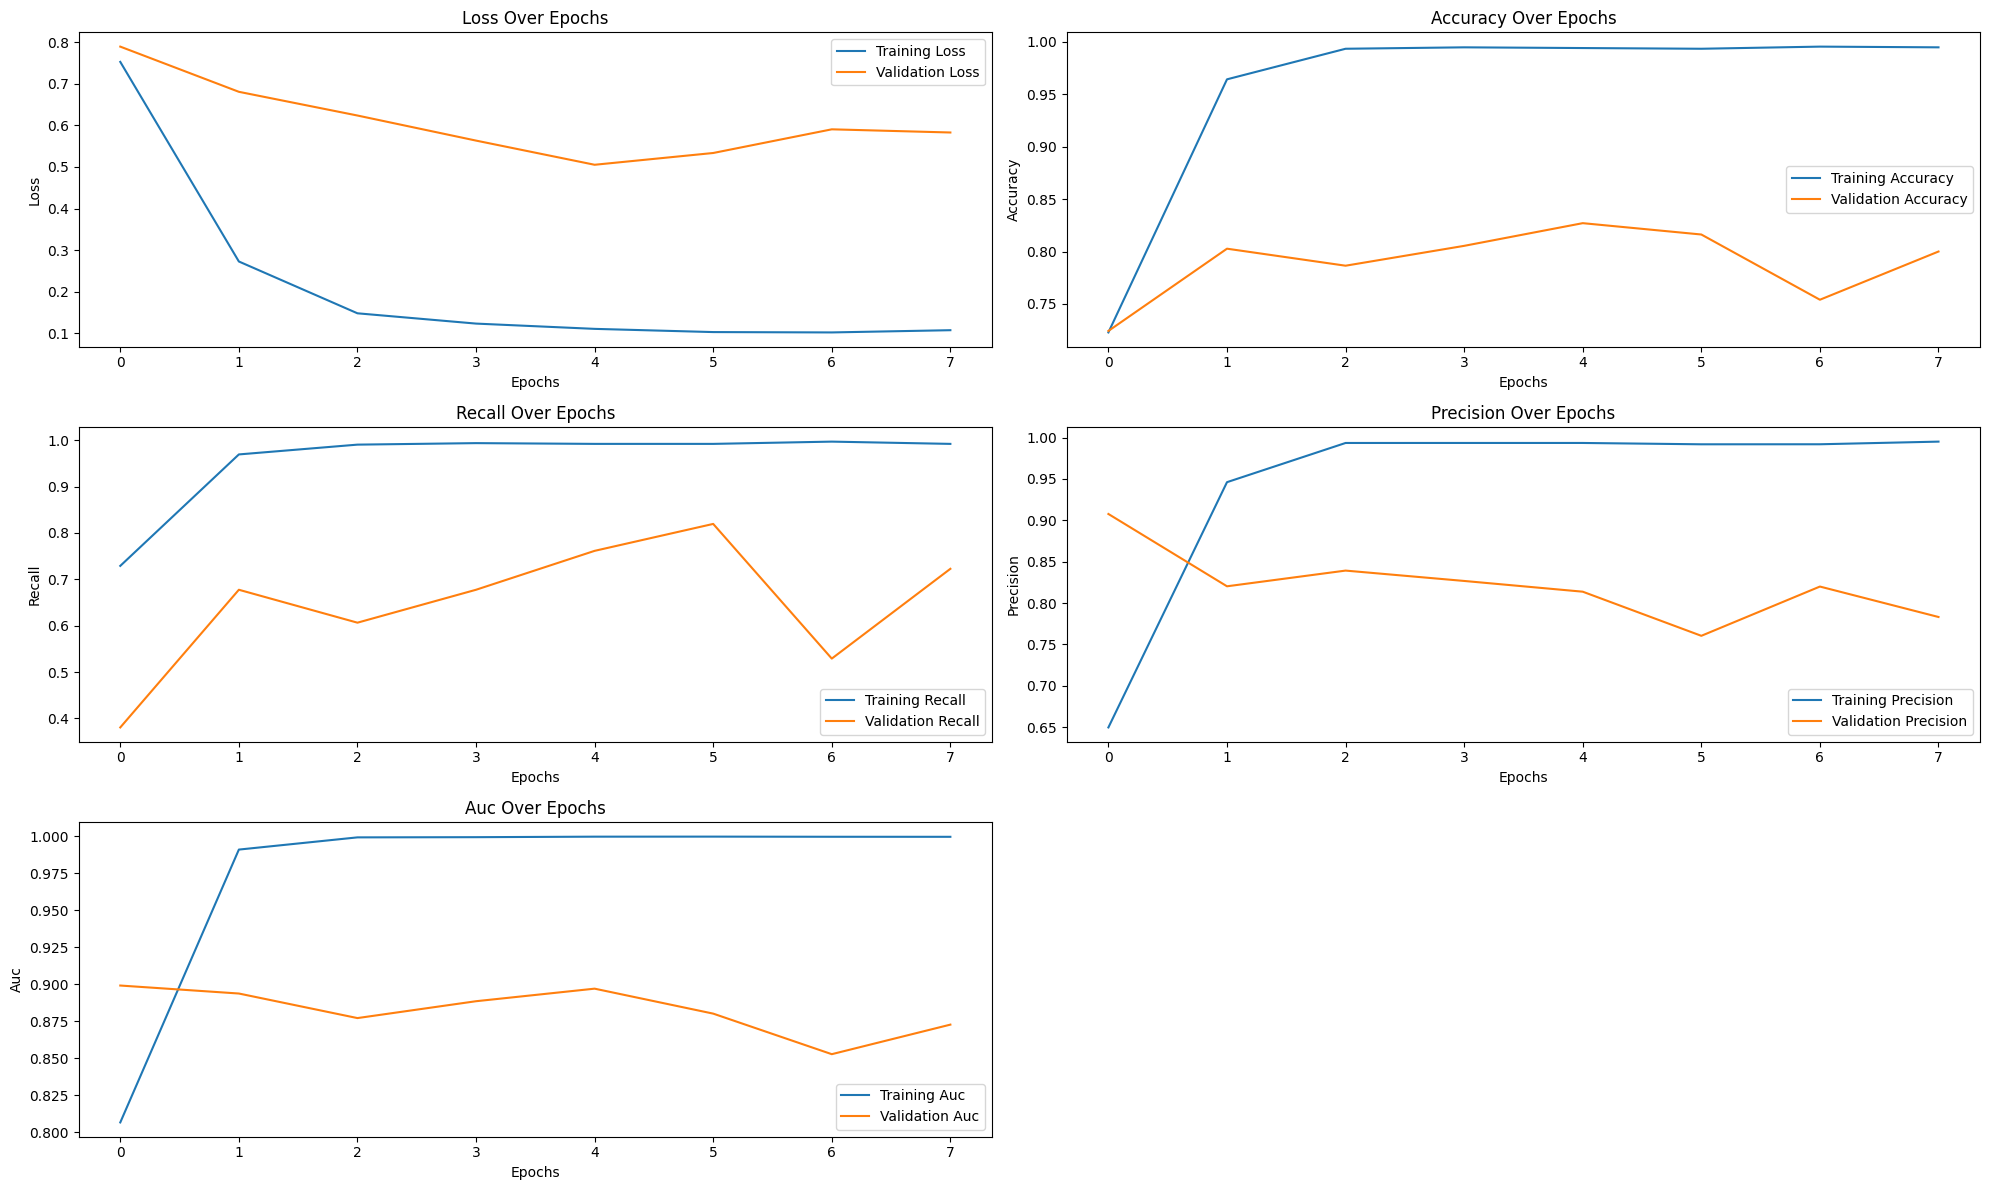


Final Training Loss: 0.1079
Final Validation Loss: 0.5827

Final Training Accuracy: 0.9946
Final Validation Accuracy: 0.8000

Final Training Recall: 0.9919
Final Validation Recall: 0.7226

Final Training Precision: 0.9951
Final Validation Precision: 0.7832

Final Training Auc: 0.9997
Final Validation Auc: 0.8727


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - AUC: 0.9077 - accuracy: 0.8092 - loss: 0.4881 - precision: 0.7749 - recall: 0.7618
{'AUC': 0.8939364552497864, 'accuracy': 0.8008658289909363, 'loss': 0.5094902515411377, 'precision': 0.7759562730789185, 'recall': 0.7357512712478638}
Test Loss: 0.5094902515411377
Test Accuracy: 0.8008658289909363
Test Recall: 0.7357512712478638
Test Precision: 0.7759562730789185
Test Auc: 0.8939364552497864


In [33]:
### One Layer LSTM with Regularisation - BatchNorm & Dropout

model_lstm_1_reg_bn = deep_learning_utils.create_lstm_model(vectorize_layer=vectorize_layer,
                                        embedding_dim=200,
                                        lstm_units=32,
                                        num_lstm_layers=1,
                                        num_classes=1,
                                        seed=seed,
                                        dropout_rate=0.3,
                                        l2_lambda=0.001,
                                        metrics = metrics,
                                        batch_normalization=True)

model_lstm_1_reg_bn.summary()

model_description = 'One Layer LSTM (32), Regularisation, Batch Normalization, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_1_reg_bn,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_10        │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 128)       │    168,448 │ embedding_10[0][… │
│                     │                   │            │ not_equal_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ lstm_3[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │        129 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,504,089 (17.18 MB)

 Trainable params: 4,503,833 (17.18 MB)

 Non-trainable params: 256 (1.00 KB)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 497ms/step - AUC: 0.7531 - accuracy: 0.6880 - loss: 1.0435 - precision: 0.6139 - recall: 0.6506 - val_AUC: 0.8694 - val_accuracy: 0.5811 - val_loss: 0.8755 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 439ms/step - AUC: 0.9849 - accuracy: 0.9444 - loss: 0.3927 - precision: 0.9293 - recall: 0.9358 - val_AUC: 0.8992 - val_accuracy: 0.8162 - val_loss: 0.6349 - val_precision: 0.8595 - val_recall: 0.6710
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 379ms/step - AUC: 0.9989 - accuracy: 0.9908 - loss: 0.2016 - precision: 0.9863 - recall: 0.9913 - val_AUC: 0.8848 - val_accuracy: 0.7351 - val_loss: 0.6432 - val_precision: 0.9014 - val_recall: 0.4129
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 388ms/step - AUC: 0.9999 - accuracy: 0.9956 - loss: 0.1511 - precision: 0.9932 - recall: 0.9963 - val_AUC: 0.8855 - val_accuracy: 0.7486 - val_loss: 0.5962 - val_precision: 0.8370 - v

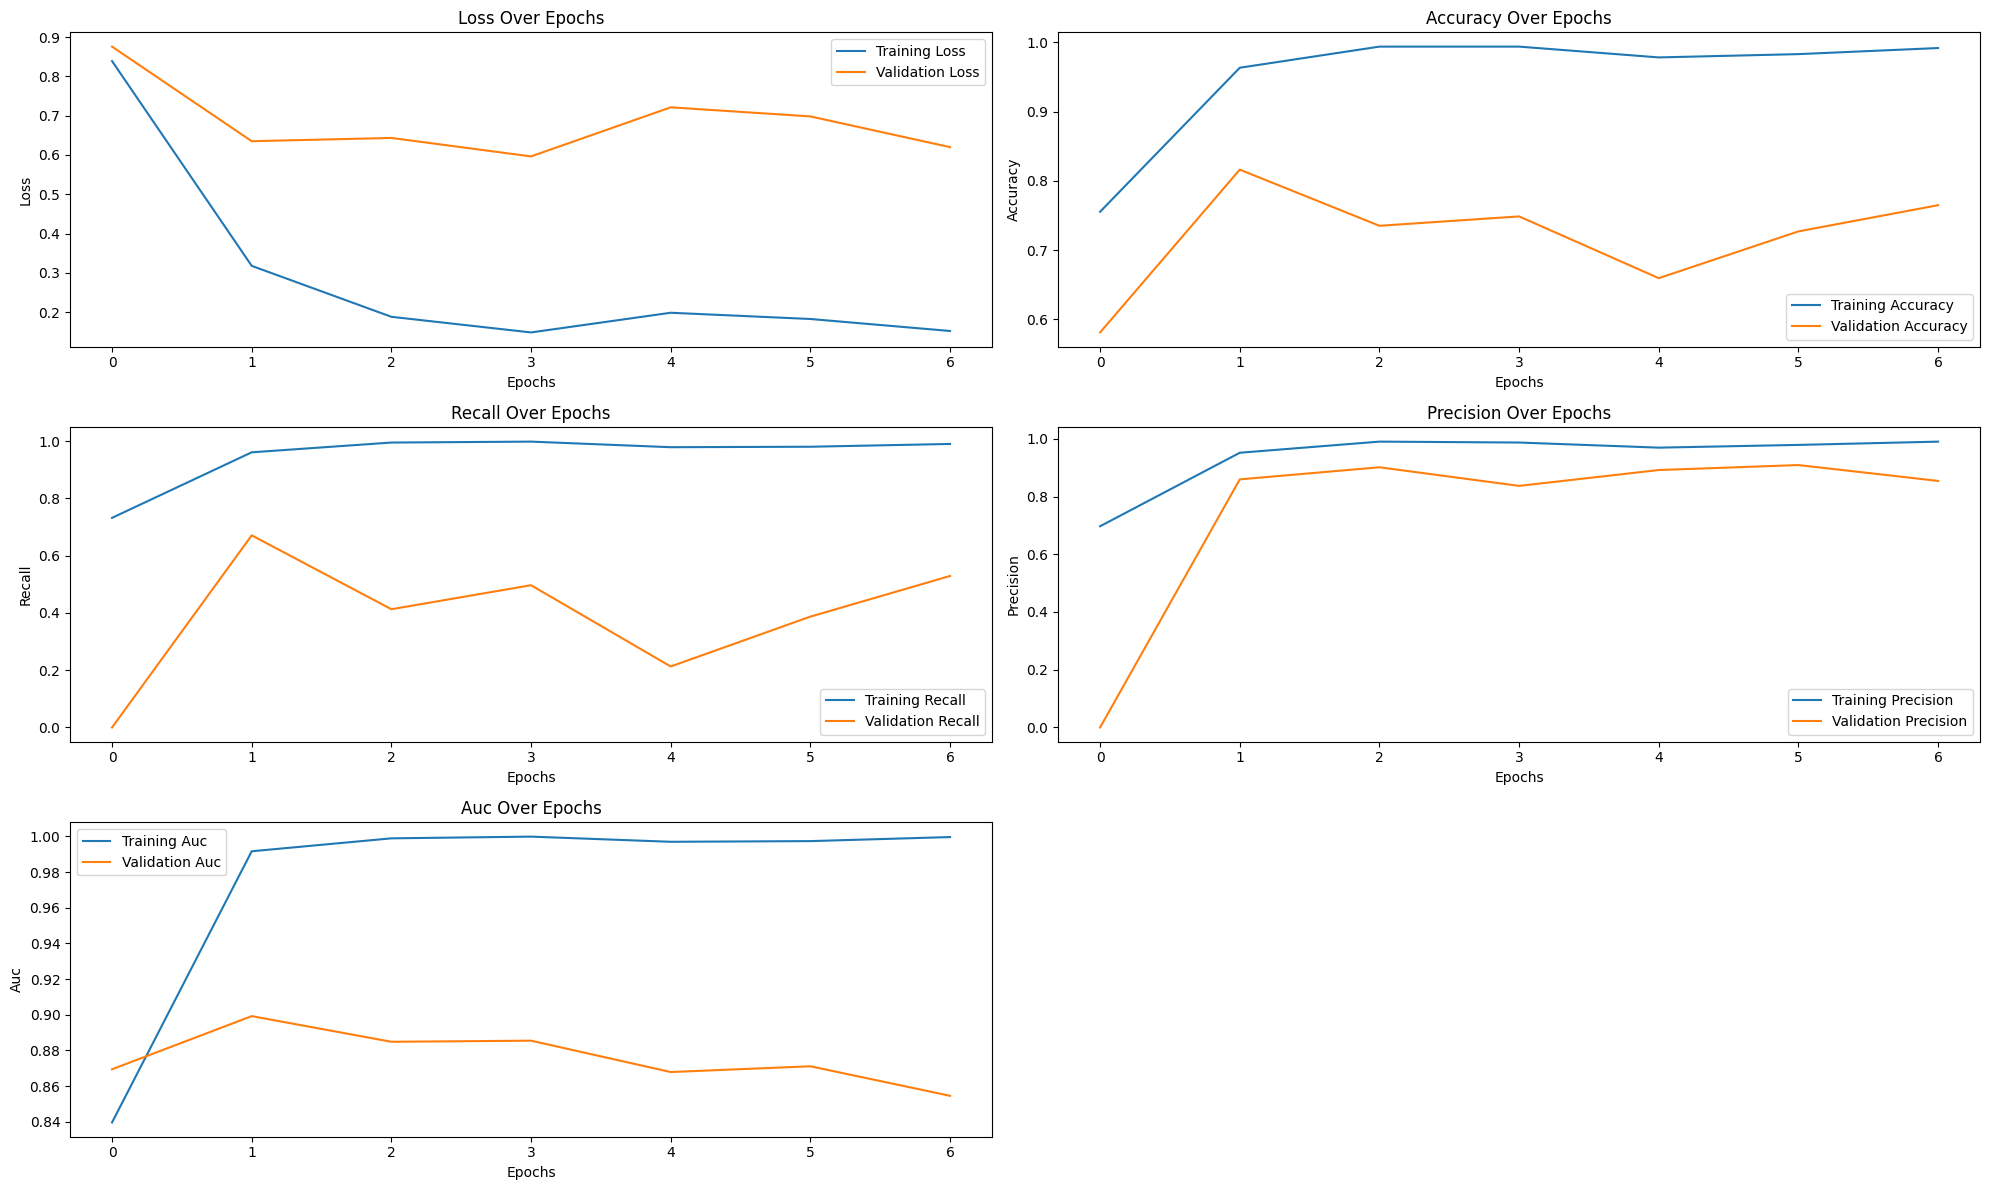


Final Training Loss: 0.1521
Final Validation Loss: 0.6198

Final Training Accuracy: 0.9919
Final Validation Accuracy: 0.7649

Final Training Recall: 0.9903
Final Validation Recall: 0.5290

Final Training Precision: 0.9903
Final Validation Precision: 0.8542

Final Training Auc: 0.9997
Final Validation Auc: 0.8546


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - AUC: 0.9144 - accuracy: 0.8175 - loss: 0.5663 - precision: 0.9348 - recall: 0.6005
{'AUC': 0.8943024277687073, 'accuracy': 0.7813853025436401, 'loss': 0.5897271633148193, 'precision': 0.9107142686843872, 'recall': 0.5284973978996277}
Test Loss: 0.5897271633148193
Test Accuracy: 0.7813853025436401
Test Recall: 0.5284973978996277
Test Precision: 0.9107142686843872
Test Auc: 0.8943024277687073


In [34]:
### One Layer LSTM with Regularisation - BatchNorm & Dropout - 128 lstm units

model_lstm_1_reg_bn_128 = deep_learning_utils.create_lstm_model(vectorize_layer=vectorize_layer,
                                        embedding_dim=200,
                                        lstm_units=128,
                                        num_lstm_layers=1,
                                        num_classes=1,
                                        seed=seed,
                                        dropout_rate=0.3,
                                        l2_lambda=0.001,
                                        metrics = metrics,
                                        batch_normalization=True)

model_lstm_1_reg_bn_128.summary()

model_description = 'One Layer LSTM (128), Regularisation, Batch Normalization, Embeddings size: 200, LSTM units: 128'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_1_reg_bn_128,
                                                             
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### Two Layer LSTM, No Regularisation

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_11        │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 256, 32)   │     29,824 │ embedding_11[0][… │
│                     │                   │            │ not_equal_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256, 32)   │          0 │ lstm_4[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 32)        │      8,320 │ dropout_14[0][0], │
│                     │                   │            │ not_equal_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32)        │          0 │ lstm_5[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         33 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,373,177 (16.68 MB)

 Trainable params: 4,373,177 (16.68 MB)

 Non-trainable params: 0 (0.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 418ms/step - AUC: 0.6536 - accuracy: 0.6159 - loss: 0.6288 - precision: 0.5528 - recall: 0.1773 - val_AUC: 0.9070 - val_accuracy: 0.8568 - val_loss: 0.3855 - val_precision: 0.7898 - val_recall: 0.8968
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 332ms/step - AUC: 0.9824 - accuracy: 0.9354 - loss: 0.1935 - precision: 0.9208 - recall: 0.9220 - val_AUC: 0.8972 - val_accuracy: 0.8108 - val_loss: 0.5121 - val_precision: 0.7429 - val_recall: 0.8387
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 304ms/step - AUC: 0.9971 - accuracy: 0.9808 - loss: 0.0640 - precision: 0.9657 - recall: 0.9885 - val_AUC: 0.8466 - val_accuracy: 0.8000 - val_loss: 0.8116 - val_precision: 0.7914 - val_recall: 0.7097
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 279ms/step - AUC: 0.9987 - accuracy: 0.9979 - loss: 0.0141 - precision: 0.9967 - recall: 0.9982 - val_AUC: 0.8699 - val_accuracy: 0.7892 - val_loss: 0.8027 - val_precision: 0.7655 - val_recal

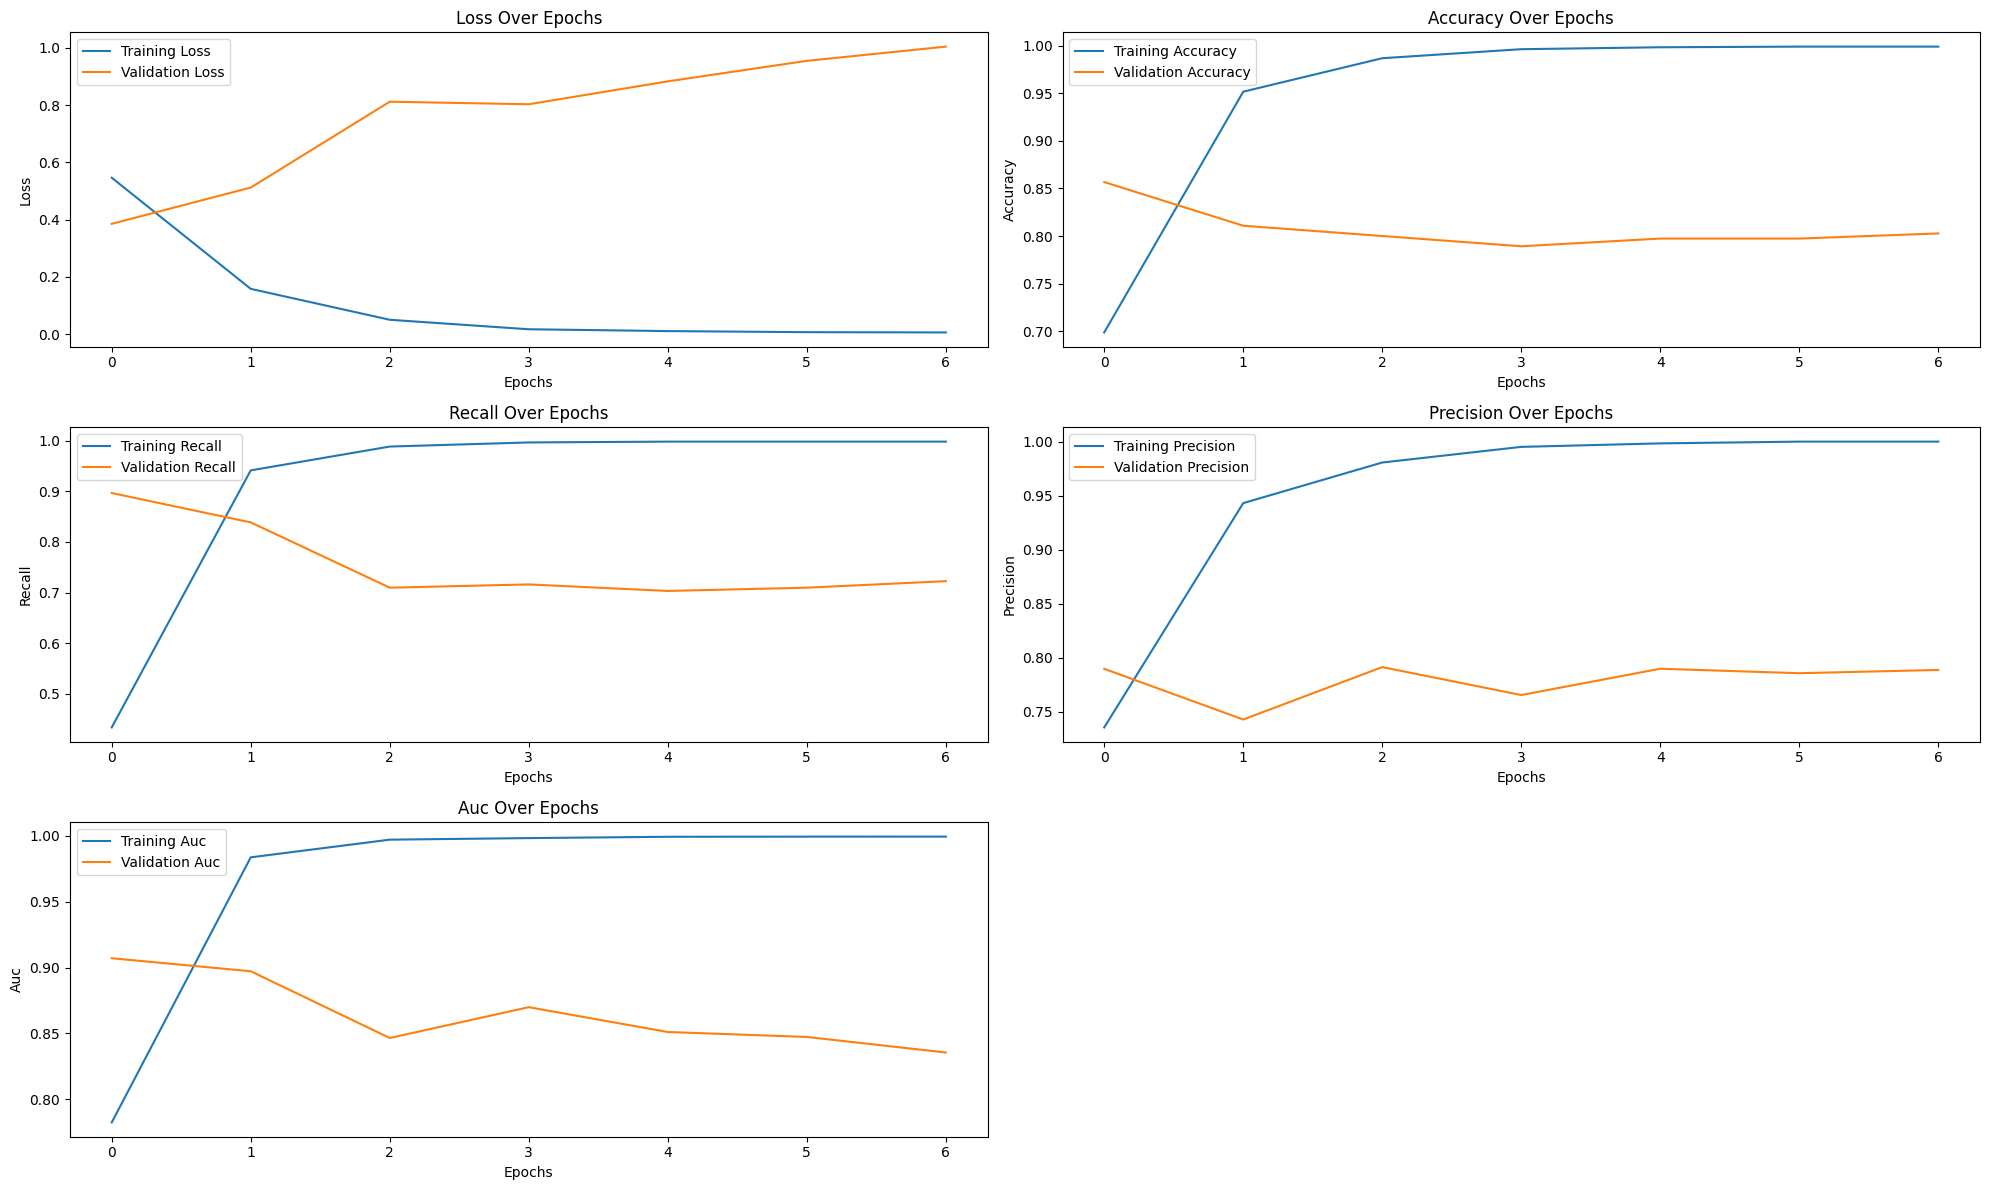


Final Training Loss: 0.0066
Final Validation Loss: 1.0038

Final Training Accuracy: 0.9993
Final Validation Accuracy: 0.8027

Final Training Recall: 0.9984
Final Validation Recall: 0.7226

Final Training Precision: 1.0000
Final Validation Precision: 0.7887

Final Training Auc: 0.9992
Final Validation Auc: 0.8356


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - AUC: 0.9046 - accuracy: 0.8263 - loss: 0.5752 - precision: 0.8069 - recall: 0.7670
{'AUC': 0.8966619372367859, 'accuracy': 0.8160173296928406, 'loss': 0.6135527491569519, 'precision': 0.7967032790184021, 'recall': 0.7512953281402588}
Test Loss: 0.6135527491569519
Test Accuracy: 0.8160173296928406
Test Recall: 0.7512953281402588
Test Precision: 0.7967032790184021
Test Auc: 0.8966619372367859


In [35]:
### Two Layer LSTM, No Regularisation

model_lstm_2 = deep_learning_utils.create_lstm_model(vectorize_layer=vectorize_layer,
                                    embedding_dim=200,
                                    lstm_units=32,
                                    num_lstm_layers=2,
                                    num_classes=1,
                                    seed=seed,
                                    dropout_rate=0,
                                    l2_lambda=0,
                                    metrics = metrics)

model_lstm_2.summary()

model_description = 'Two Layer LSTM (32), No Regularisation, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_2,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### Two Layer LSTM, Regularised L2 + Dropout

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_12        │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 256, 32)   │     29,824 │ embedding_12[0][… │
│                     │                   │            │ not_equal_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 256, 32)   │          0 │ lstm_6[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 32)        │      8,320 │ dropout_16[0][0], │
│                     │                   │            │ not_equal_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 32)        │          0 │ lstm_7[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         33 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,373,177 (16.68 MB)

 Trainable params: 4,373,177 (16.68 MB)

 Non-trainable params: 0 (0.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 422ms/step - AUC: 0.5901 - accuracy: 0.5932 - loss: 1.0169 - precision: 0.4782 - recall: 0.1002 - val_AUC: 0.9035 - val_accuracy: 0.8324 - val_loss: 0.5583 - val_precision: 0.7688 - val_recall: 0.8581
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 304ms/step - AUC: 0.9375 - accuracy: 0.8610 - loss: 0.4927 - precision: 0.8316 - recall: 0.8297 - val_AUC: 0.9116 - val_accuracy: 0.8568 - val_loss: 0.5409 - val_precision: 0.7965 - val_recall: 0.8839
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 309ms/step - AUC: 0.9869 - accuracy: 0.9668 - loss: 0.2679 - precision: 0.9457 - recall: 0.9752 - val_AUC: 0.8826 - val_accuracy: 0.7919 - val_loss: 0.7385 - val_precision: 0.7010 - val_recall: 0.8774
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - AUC: 0.9937 - accuracy: 0.9840 - loss: 0.1976 - precision: 0.9722 - recall: 0.9895 - val_AUC: 0.8813 - val_accuracy: 0.8135 - val_loss: 0.7280 - val_precision: 0.8028 - val_recal

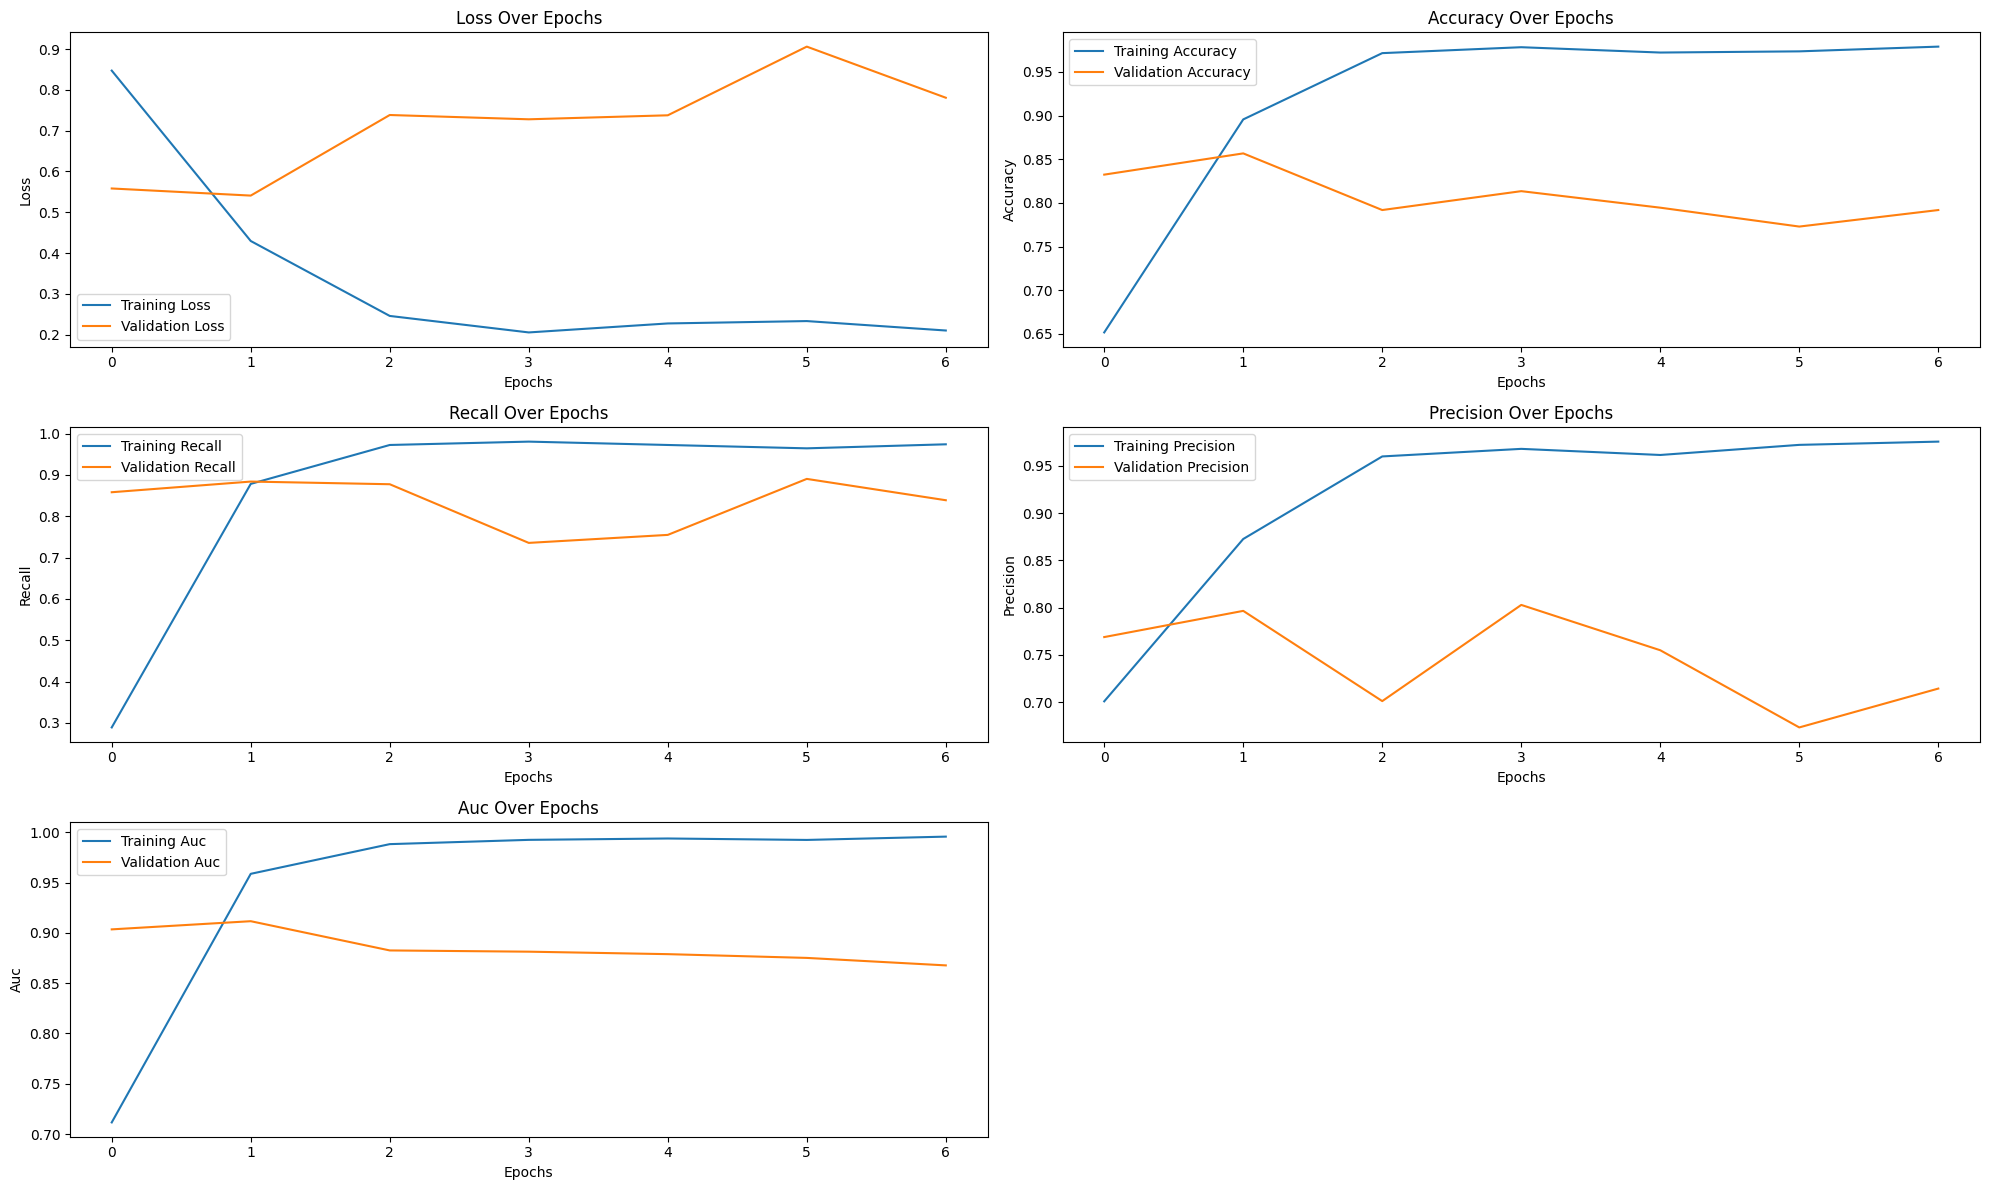


Final Training Loss: 0.2100
Final Validation Loss: 0.7809

Final Training Accuracy: 0.9790
Final Validation Accuracy: 0.7919

Final Training Recall: 0.9740
Final Validation Recall: 0.8387

Final Training Precision: 0.9756
Final Validation Precision: 0.7143

Final Training Auc: 0.9957
Final Validation Auc: 0.8677


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - AUC: 0.9173 - accuracy: 0.8303 - loss: 0.6020 - precision: 0.8160 - recall: 0.7652
{'AUC': 0.8959493041038513, 'accuracy': 0.8051947951316833, 'loss': 0.6639440059661865, 'precision': 0.7976878881454468, 'recall': 0.7150259017944336}
Test Loss: 0.6639440059661865
Test Accuracy: 0.8051947951316833
Test Recall: 0.7150259017944336
Test Precision: 0.7976878881454468
Test Auc: 0.8959493041038513


In [36]:
### Two Layer LSTM, Regularised L2 + Dropout

model_lstm_2_reg = deep_learning_utils.create_lstm_model(vectorize_layer=vectorize_layer,
                                        embedding_dim=200,
                                        lstm_units=32,
                                        num_lstm_layers=2,
                                        num_classes=1,
                                        seed=seed,
                                        dropout_rate=0.3,
                                        l2_lambda=0.001,
                                        metrics = metrics)

model_lstm_2_reg.summary()

model_description = 'Two Layer LSTM (32), Regularisation, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_2_reg,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### Two Layers LSTM with Regularisation - BatchNorm & Dropout

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_13        │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 256, 64)   │     67,840 │ embedding_13[0][… │
│                     │                   │            │ not_equal_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ lstm_8[0][0],     │
│ (BatchNormalizatio… │                   │            │ not_equal_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 256, 64)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 64)        │     33,024 │ dropout_18[0][0], │
│                     │                   │            │ not_equal_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ lstm_9[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         65 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,436,441 (16.92 MB)

 Trainable params: 4,436,185 (16.92 MB)

 Non-trainable params: 256 (1.00 KB)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 511ms/step - AUC: 0.7000 - accuracy: 0.6462 - loss: 1.2553 - precision: 0.5625 - recall: 0.6438 - val_AUC: 0.8890 - val_accuracy: 0.5811 - val_loss: 1.0405 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 387ms/step - AUC: 0.9820 - accuracy: 0.9333 - loss: 0.5499 - precision: 0.9073 - recall: 0.9341 - val_AUC: 0.8670 - val_accuracy: 0.5919 - val_loss: 0.9344 - val_precision: 1.0000 - val_recall: 0.0258
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 475ms/step - AUC: 0.9911 - accuracy: 0.9742 - loss: 0.3986 - precision: 0.9702 - recall: 0.9670 - val_AUC: 0.8575 - val_accuracy: 0.5811 - val_loss: 0.9194 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - AUC: 0.9979 - accuracy: 0.9876 - loss: 0.3180 - precision: 0.9871 - recall: 0.9827 - val_AUC: 0.8623 - val_accuracy: 0.6027 - val_loss: 0.8543 - val_precision: 1.

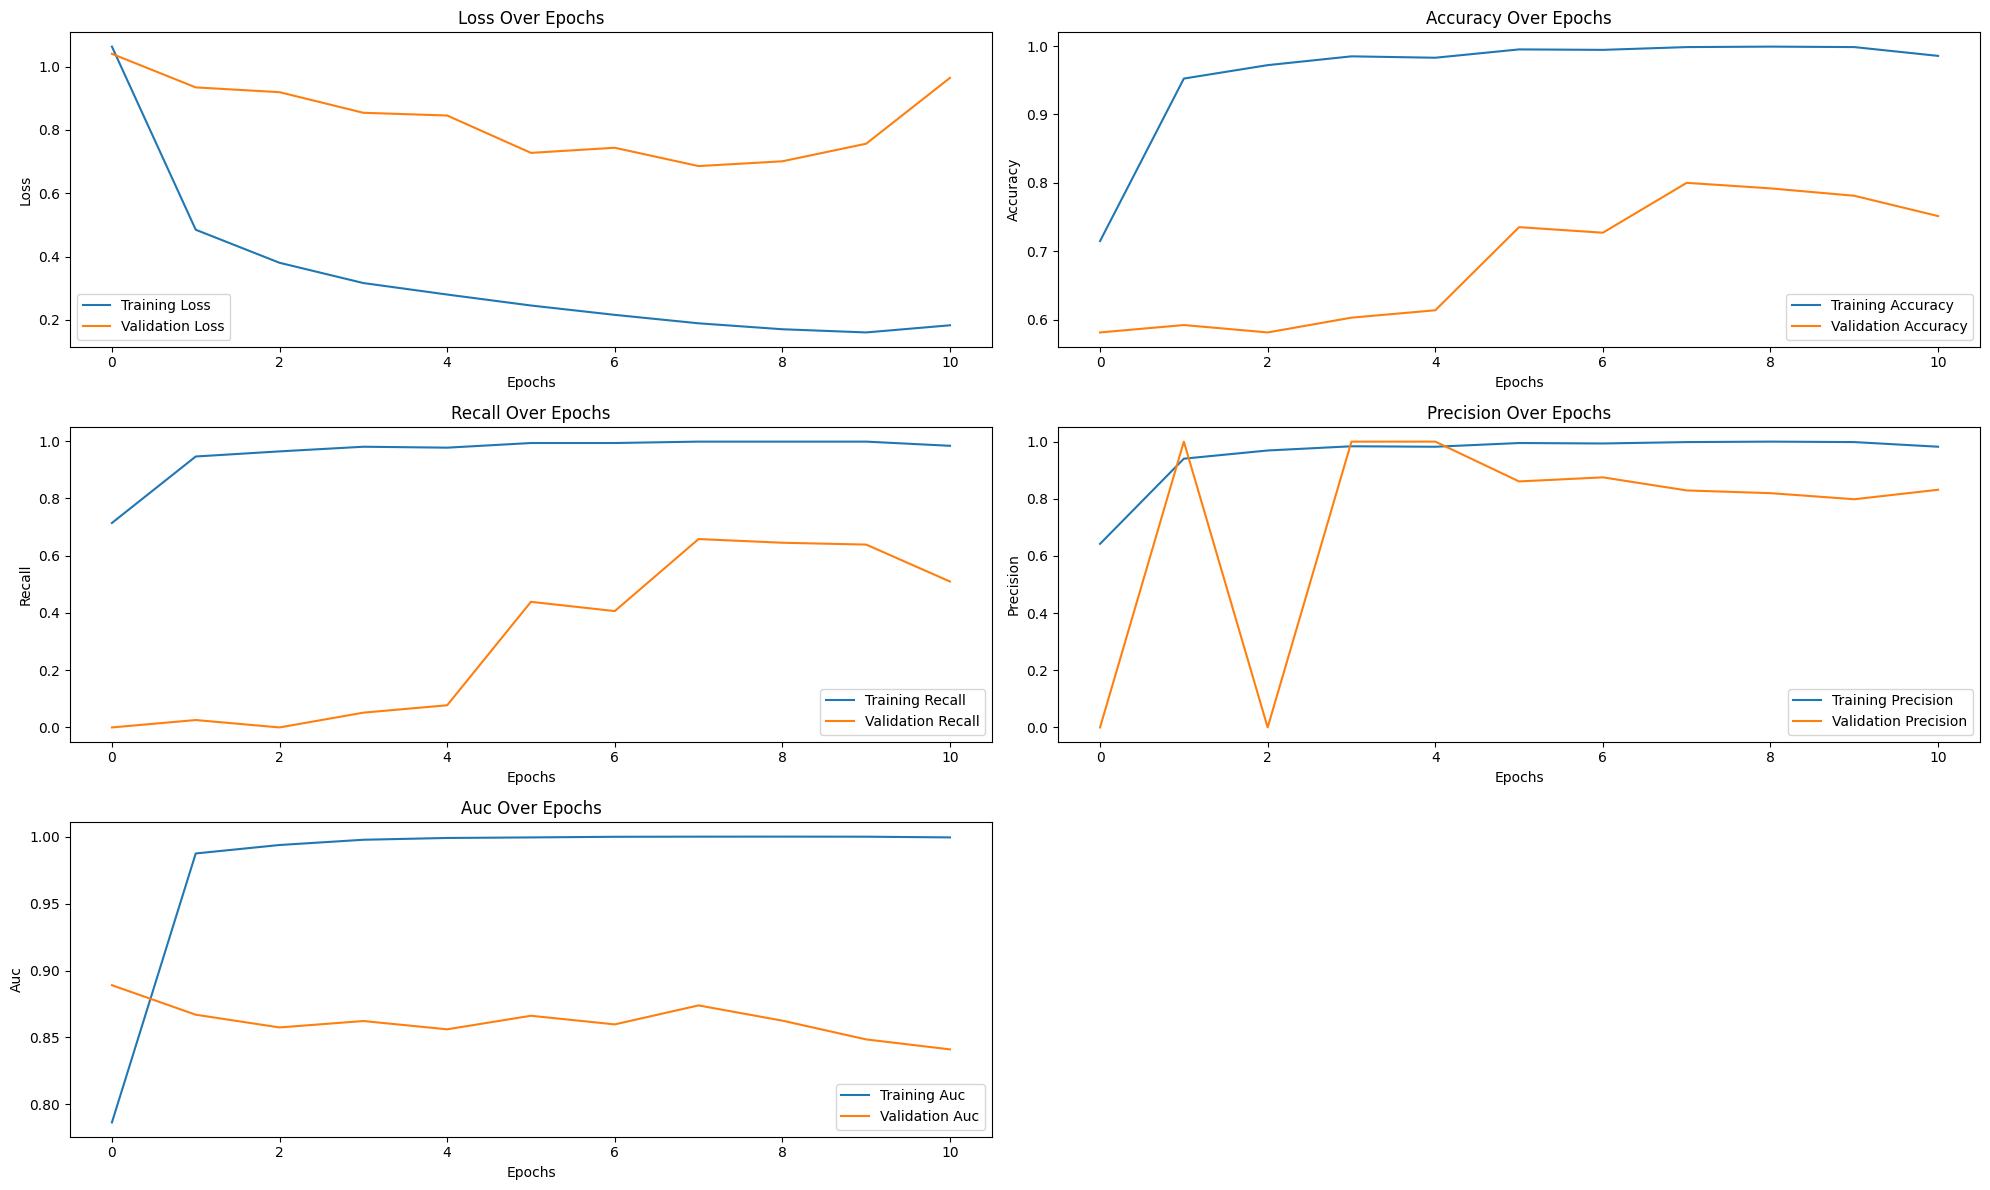


Final Training Loss: 0.1833
Final Validation Loss: 0.9646

Final Training Accuracy: 0.9858
Final Validation Accuracy: 0.7514

Final Training Recall: 0.9838
Final Validation Recall: 0.5097

Final Training Precision: 0.9822
Final Validation Precision: 0.8316

Final Training Auc: 0.9994
Final Validation Auc: 0.8411


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - AUC: 0.9057 - accuracy: 0.8360 - loss: 0.5850 - precision: 0.8884 - recall: 0.6917
{'AUC': 0.885991096496582, 'accuracy': 0.8095238208770752, 'loss': 0.6431843638420105, 'precision': 0.8620689511299133, 'recall': 0.6476684212684631}
Test Loss: 0.6431843638420105
Test Accuracy: 0.8095238208770752
Test Recall: 0.6476684212684631
Test Precision: 0.8620689511299133
Test Auc: 0.885991096496582


In [37]:
### Two Layers LSTM with Regularisation - BatchNorm & Dropout

model_lstm_2_reg_bn = deep_learning_utils.create_lstm_model(vectorize_layer=vectorize_layer,
                                        embedding_dim=200,
                                        lstm_units=64,
                                        num_lstm_layers=2,
                                        num_classes=1,
                                        seed=seed,
                                        dropout_rate=0.3,
                                        l2_lambda=0.001,
                                        metrics = metrics,
                                        batch_normalization=True)

model_lstm_2_reg_bn.summary()

model_description = 'Two Layer LSTM (64), Regularisation, Batch Normalization, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_2_reg_bn,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_14        │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 256, 128)  │    168,448 │ embedding_14[0][… │
│                     │                   │            │ not_equal_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 256, 128)  │          0 │ lstm_10[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 256, 128)  │    131,584 │ dropout_20[0][0], │
│                     │                   │            │ not_equal_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 256, 128)  │          0 │ lstm_11[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 128)       │    131,584 │ dropout_21[0][0], │
│                     │                   │            │ not_equal_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 128)       │          0 │ lstm_12[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │        129 │ dropout_22[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,766,745 (18.18 MB)

 Trainable params: 4,766,745 (18.18 MB)

 Non-trainable params: 0 (0.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - AUC: 0.5748 - accuracy: 0.6186 - loss: 1.5613 - precision: 0.6137 - recall: 0.1639 - val_AUC: 0.9022 - val_accuracy: 0.8081 - val_loss: 0.7153 - val_precision: 0.8750 - val_recall: 0.6323
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - AUC: 0.9219 - accuracy: 0.8547 - loss: 0.5974 - precision: 0.8480 - recall: 0.7869 - val_AUC: 0.8931 - val_accuracy: 0.8081 - val_loss: 0.5833 - val_precision: 0.8043 - val_recall: 0.7161
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - AUC: 0.9895 - accuracy: 0.9624 - loss: 0.2896 - precision: 0.9539 - recall: 0.9546 - val_AUC: 0.8968 - val_accuracy: 0.8216 - val_loss: 0.7750 - val_precision: 0.7354 - val_recall: 0.8968
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 843ms/step - AUC: 0.9947 - accuracy: 0.9759 - loss: 0.2277 - precision: 0.9703 - recall: 0.9713 - val_AUC: 0.8768 - val_accuracy: 0.7486 - val_loss: 0.9520 - val_precision: 0.6435 - val_recall: 0.8968

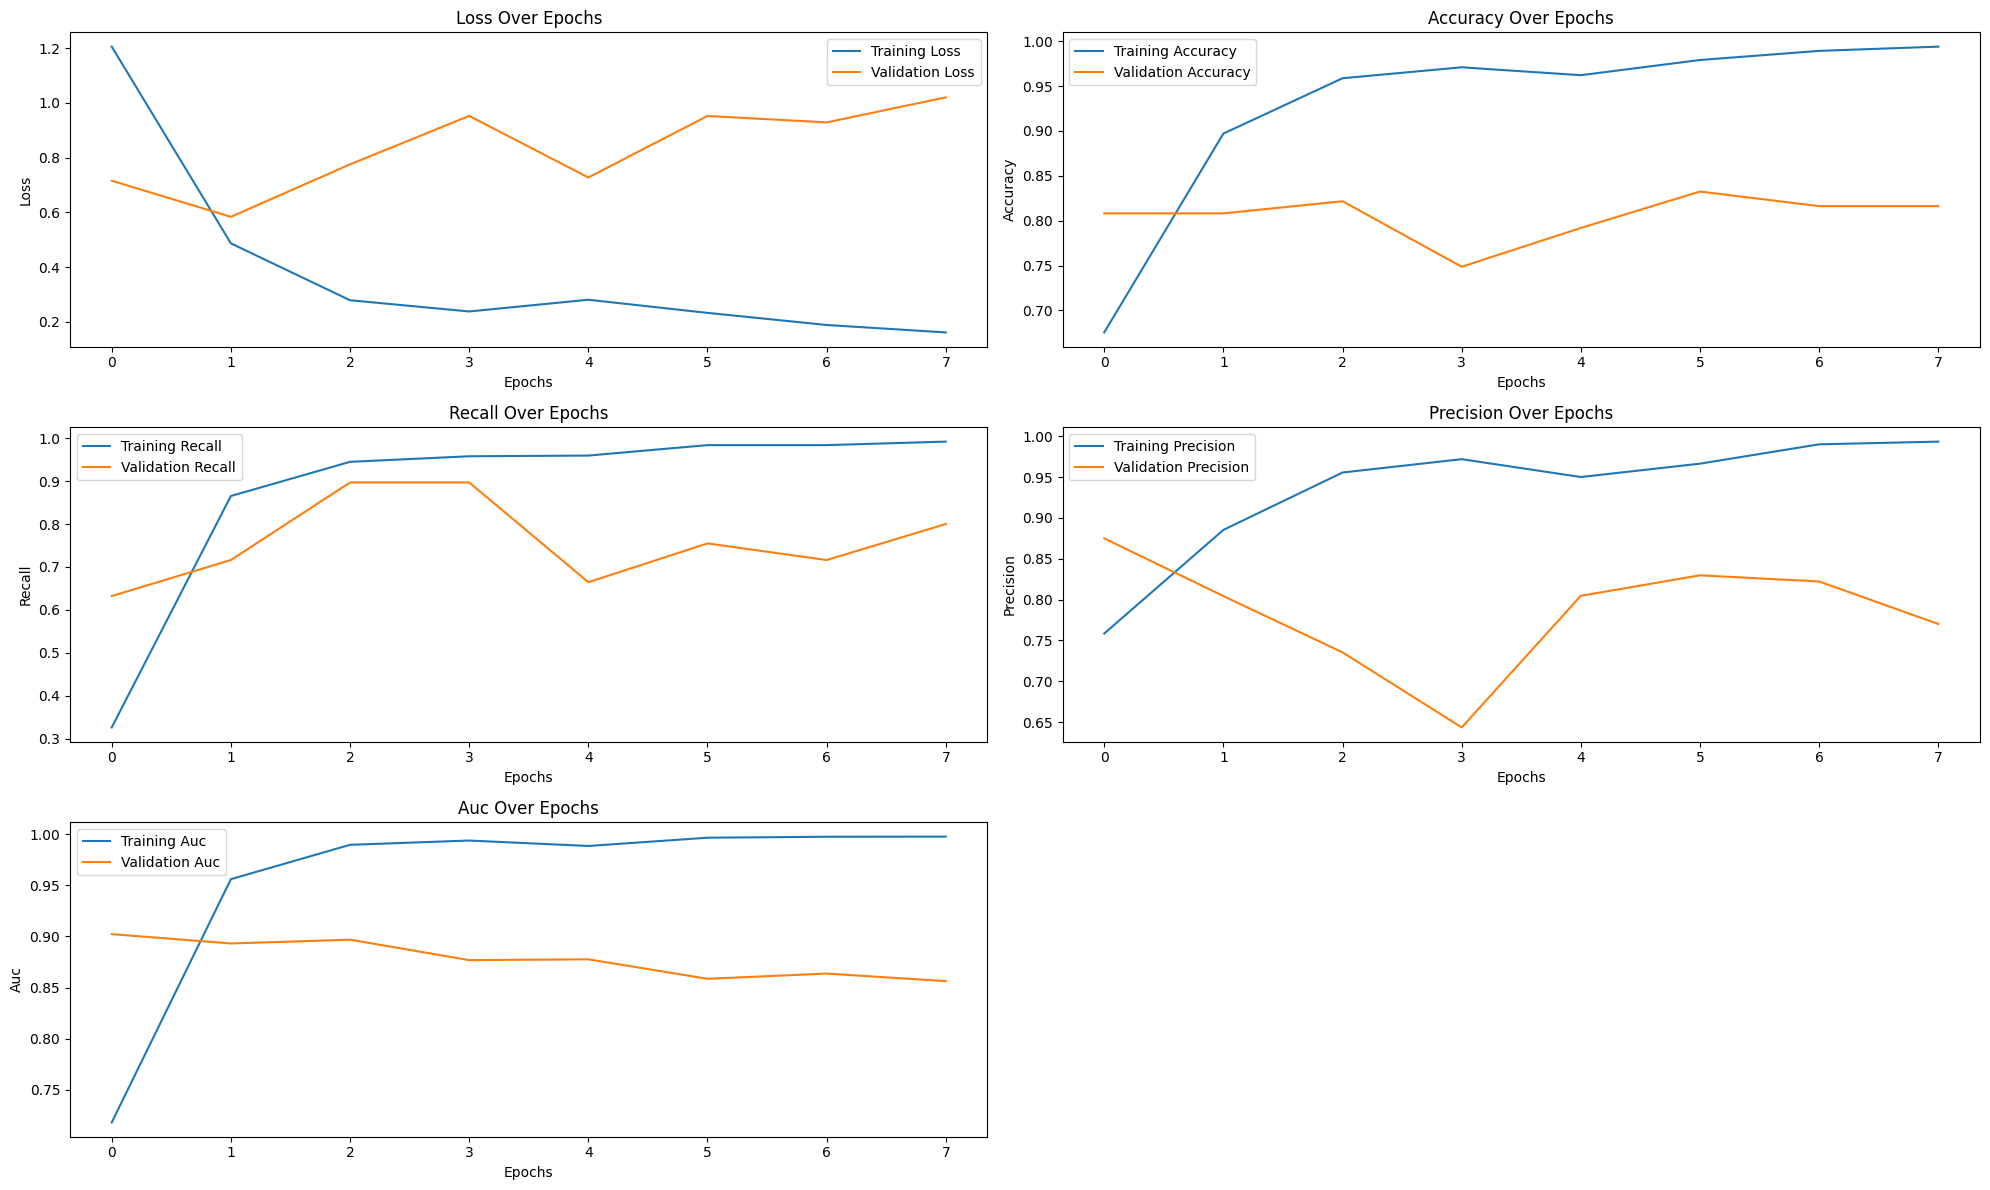


Final Training Loss: 0.1611
Final Validation Loss: 1.0198

Final Training Accuracy: 0.9939
Final Validation Accuracy: 0.8162

Final Training Recall: 0.9919
Final Validation Recall: 0.8000

Final Training Precision: 0.9935
Final Validation Precision: 0.7702

Final Training Auc: 0.9976
Final Validation Auc: 0.8562


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - AUC: 0.8925 - accuracy: 0.7858 - loss: 0.6871 - precision: 0.7469 - recall: 0.7364
{'AUC': 0.8802800178527832, 'accuracy': 0.7878788113594055, 'loss': 0.7311426997184753, 'precision': 0.7745664715766907, 'recall': 0.6943005323410034}
Test Loss: 0.7311426997184753
Test Accuracy: 0.7878788113594055
Test Recall: 0.6943005323410034
Test Precision: 0.7745664715766907
Test Auc: 0.8802800178527832


In [38]:
### Three Layer LSTM, Regularised L2 + Dropout

model_lstm_2_reg = deep_learning_utils.create_lstm_model(vectorize_layer=vectorize_layer,
                                        embedding_dim=200,
                                        lstm_units=128,
                                        num_lstm_layers=3,
                                        num_classes=1,
                                        seed=seed,
                                        dropout_rate=0.3,
                                        l2_lambda=0.001,
                                        metrics = metrics)

model_lstm_2_reg.summary()

model_description = 'Three Layer LSTM (128), Regularisation, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_2_reg,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_15        │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_15        │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 256, 128)  │    168,448 │ embedding_15[0][… │
│                     │                   │            │ not_equal_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 128)  │        512 │ lstm_13[0][0],    │
│ (BatchNormalizatio… │                   │            │ not_equal_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 256, 128)  │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 128)       │    131,584 │ dropout_23[0][0], │
│                     │                   │            │ not_equal_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ lstm_14[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │        129 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,636,185 (17.69 MB)

 Trainable params: 4,635,673 (17.68 MB)

 Non-trainable params: 512 (2.00 KB)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 682ms/step - AUC: 0.7474 - accuracy: 0.6923 - loss: 1.4658 - precision: 0.6118 - recall: 0.6886 - val_AUC: 0.8465 - val_accuracy: 0.5811 - val_loss: 1.1733 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 583ms/step - AUC: 0.9742 - accuracy: 0.9296 - loss: 0.6729 - precision: 0.9184 - recall: 0.9076 - val_AUC: 0.8988 - val_accuracy: 0.5811 - val_loss: 1.0627 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 734ms/step - AUC: 0.9942 - accuracy: 0.9777 - loss: 0.4760 - precision: 0.9843 - recall: 0.9612 - val_AUC: 0.8772 - val_accuracy: 0.6405 - val_loss: 0.9448 - val_precision: 0.8667 - val_recall: 0.1677
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 681ms/step - AUC: 0.9968 - accuracy: 0.9741 - loss: 0.4136 - precision: 0.9704 - recall: 0.9667 - val_AUC: 0.8799 - val_accuracy: 0.7108 - val_loss: 0.9164 - val_precision: 0.

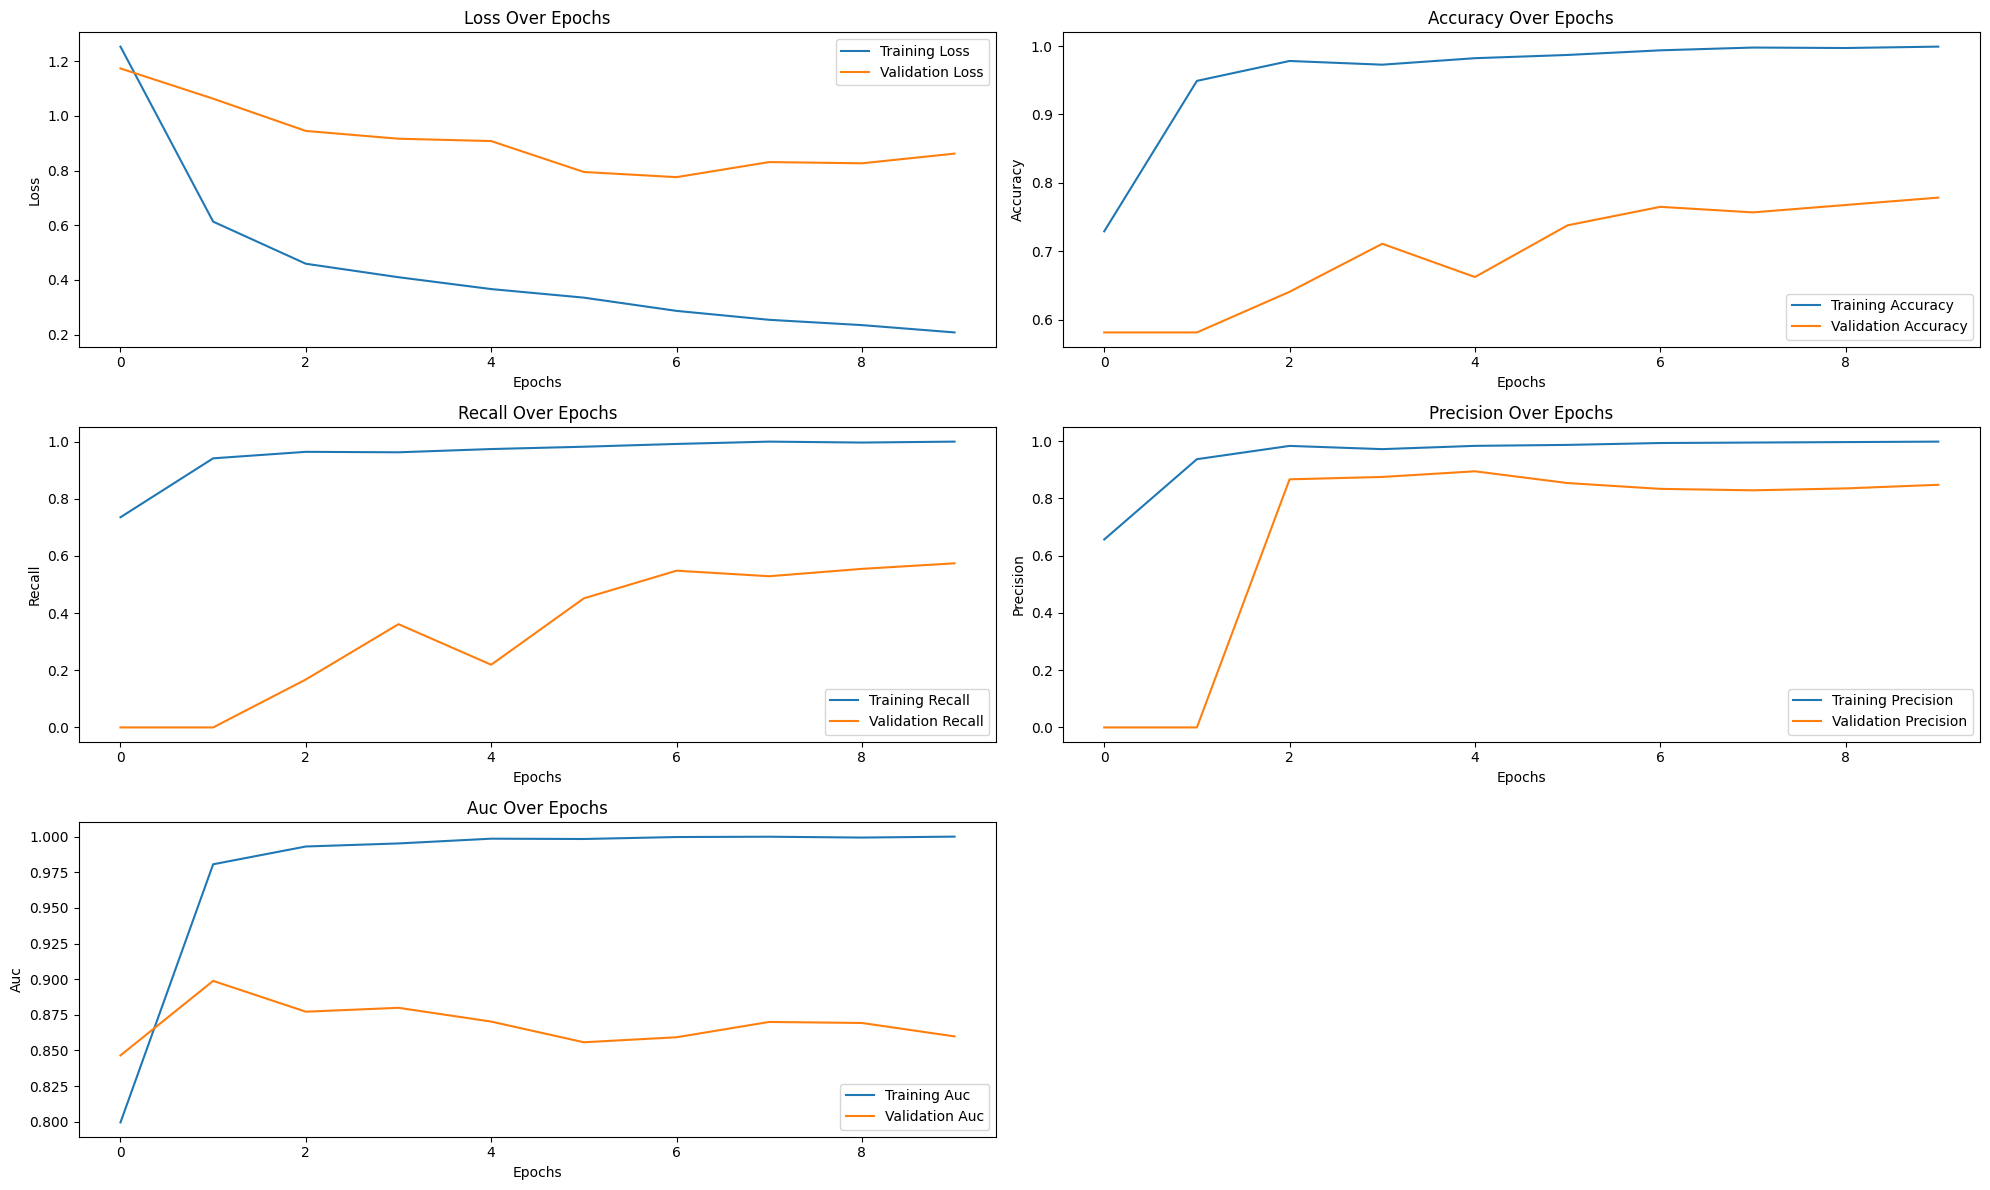


Final Training Loss: 0.2080
Final Validation Loss: 0.8619

Final Training Accuracy: 0.9993
Final Validation Accuracy: 0.7784

Final Training Recall: 1.0000
Final Validation Recall: 0.5742

Final Training Precision: 0.9984
Final Validation Precision: 0.8476

Final Training Auc: 1.0000
Final Validation Auc: 0.8599


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - AUC: 0.8857 - accuracy: 0.7783 - loss: 0.7177 - precision: 0.8887 - recall: 0.5331
{'AUC': 0.8695706725120544, 'accuracy': 0.7597402334213257, 'loss': 0.7583655714988708, 'precision': 0.8727272748947144, 'recall': 0.49740931391716003}
Test Loss: 0.7583655714988708
Test Accuracy: 0.7597402334213257
Test Recall: 0.49740931391716003
Test Precision: 0.8727272748947144
Test Auc: 0.8695706725120544


In [39]:
### Two Layer LSTM, Regularised L2 + Dropout + BatchNorm

model_lstm_2_reg_large = deep_learning_utils.create_lstm_model(vectorize_layer=vectorize_layer,
                                        embedding_dim=200,
                                        lstm_units=128,
                                        num_lstm_layers=2,
                                        num_classes=1,
                                        seed=seed,
                                        dropout_rate=0.3,
                                        l2_lambda=0.001,
                                        metrics = metrics,
                                        batch_normalization=True)

model_lstm_2_reg_large.summary()

model_description = 'Three Layer LSTM (128), Regularisation, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_2_reg_large,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

In [40]:
model_registry

,n_epochs,avg_epoch_time,test_loss,test_accuracy,test_recall,test_precision,test_AUC,model,training_time
0,7,4.611504,0.512451,0.746753,0.663212,0.711111,0.821272,NaN,NaN
1,8,6.875523,0.782720,0.590909,0.502591,0.510526,0.636757,NaN,NaN
2,7,6.412905,0.536917,0.857143,0.844560,0.819095,0.901776,NaN,NaN
3,7,5.673068,0.782241,0.690476,0.393782,0.745098,0.771308,NaN,NaN
4,7,7.542915,0.574889,0.753247,0.772021,0.680365,0.812566,NaN,NaN
5,7,10.359922,0.975503,0.673160,0.611399,0.608247,0.709960,NaN,NaN
6,7,9.256730,0.866233,0.735931,0.590674,0.726115,0.807395,NaN,NaN
7,7,7.036167,0.460066,0.844156,0.813471,0.813471,0.900428,NaN,NaN
8,7,8.856632,0.583468,0.818182,0.756477,0.797814,0.897904,NaN,NaN
9,8,8.327646,0.509490,0.800866,0.735751,0.775956,0.893936,NaN,NaN


### Bidirectional LSTM with one layer 32 neurons, embeddings 200, no regularisation

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_16        │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     59,648 │ embedding_16[0][… │
│ (Bidirectional)     │                   │            │ not_equal_16[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 64)        │          0 │ bidirectional[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │         65 │ dropout_25[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,394,713 (16.76 MB)

 Trainable params: 4,394,713 (16.76 MB)

 Non-trainable params: 0 (0.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - AUC: 0.7024 - accuracy: 0.6205 - loss: 0.6359 - precision: 0.6592 - recall: 0.1439 - val_AUC: 0.9282 - val_accuracy: 0.8622 - val_loss: 0.3477 - val_precision: 0.8133 - val_recall: 0.8710
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - AUC: 0.9825 - accuracy: 0.9325 - loss: 0.1882 - precision: 0.8998 - recall: 0.9410 - val_AUC: 0.9303 - val_accuracy: 0.8622 - val_loss: 0.3615 - val_precision: 0.7921 - val_recall: 0.9097
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - AUC: 0.9979 - accuracy: 0.9864 - loss: 0.0526 - precision: 0.9746 - recall: 0.9931 - val_AUC: 0.9276 - val_accuracy: 0.8595 - val_loss: 0.4311 - val_precision: 0.8160 - val_recall: 0.8581
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - AUC: 1.0000 - accuracy: 0.9992 - loss: 0.0109 - precision: 1.0000 - recall: 0.9980 - val_AUC: 0.9123 - val_accuracy: 0.8568 - val_loss: 0.4894 - val_precision: 0.8312 - val_recall: 

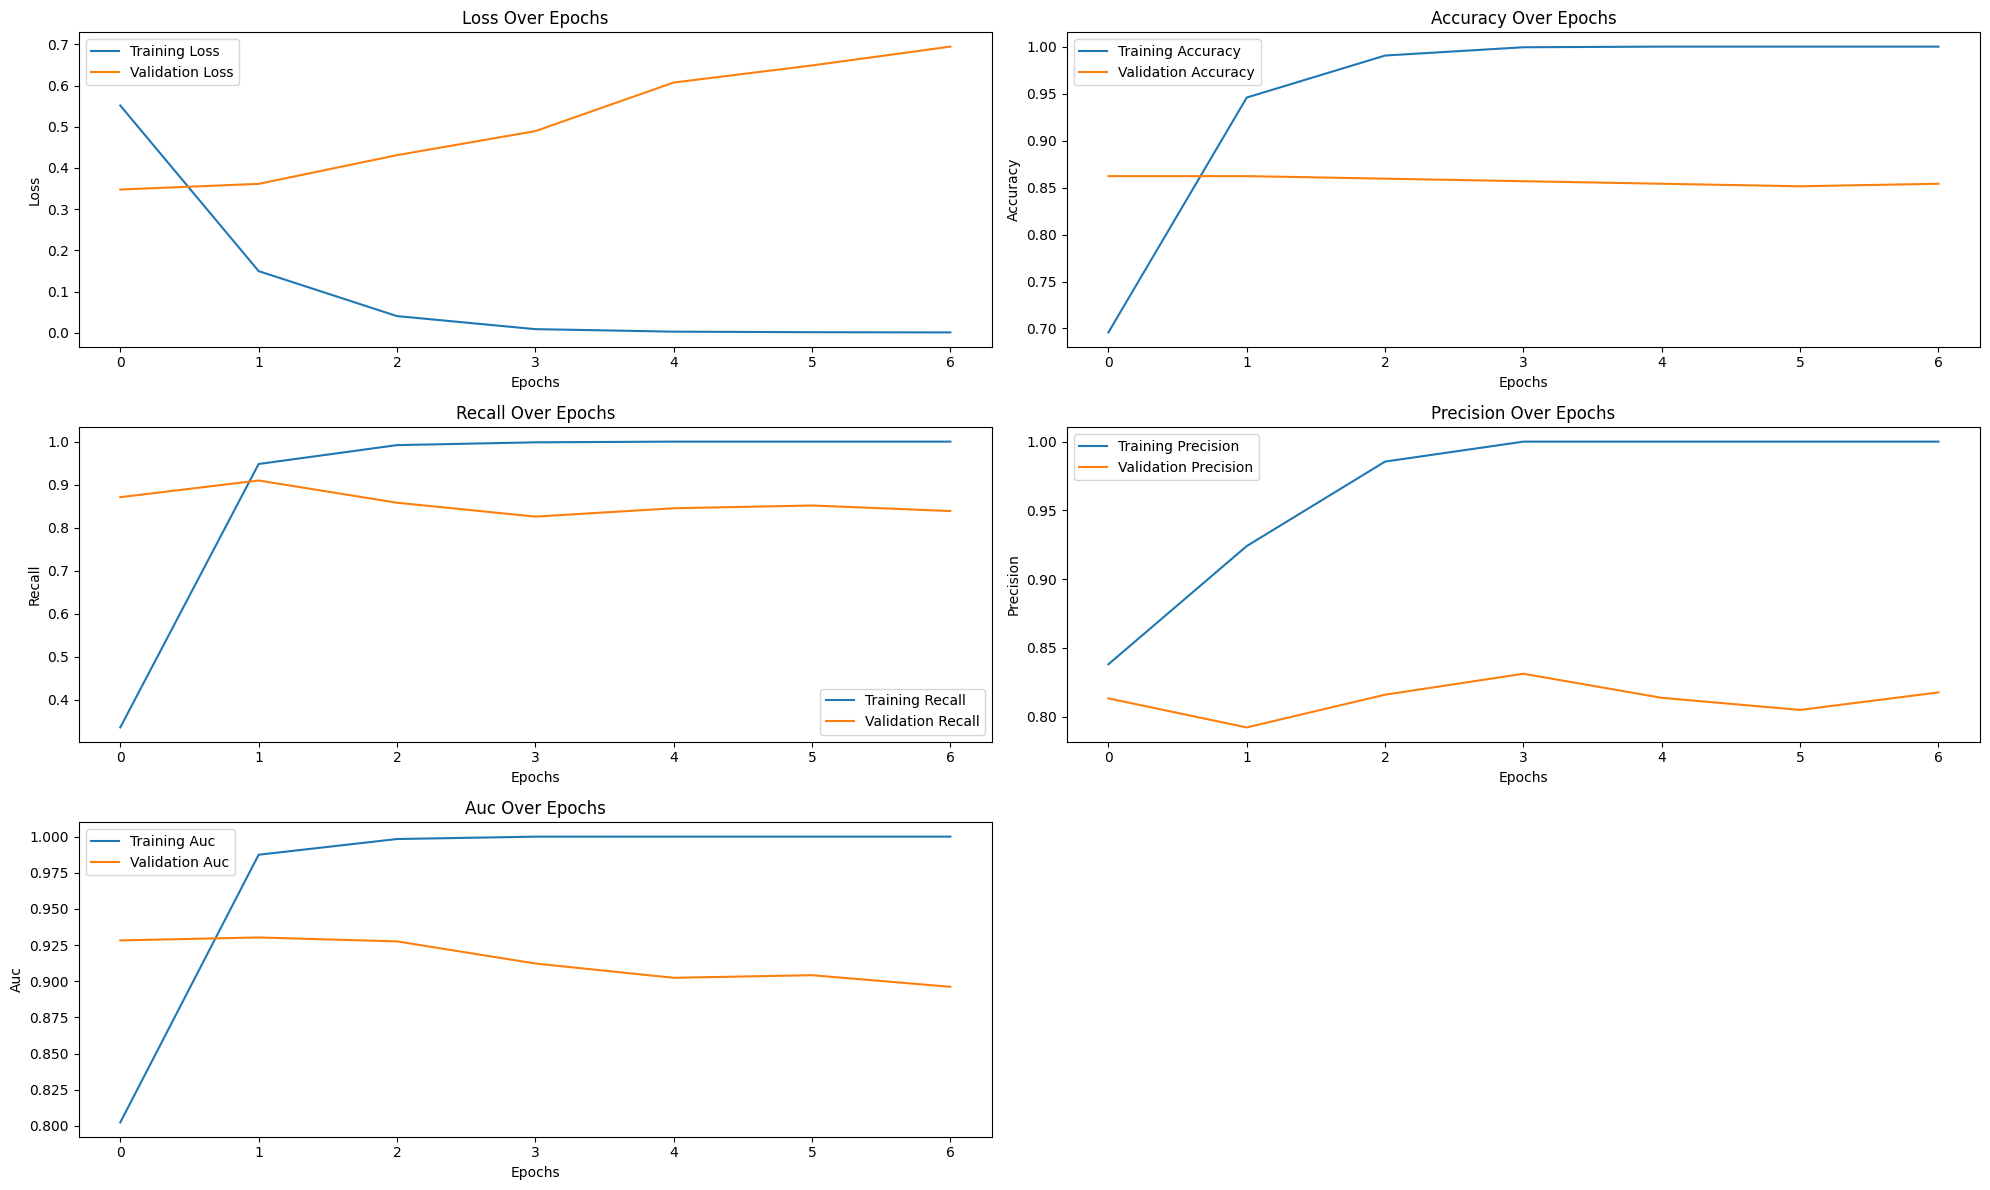


Final Training Loss: 0.0009
Final Validation Loss: 0.6945

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.8541

Final Training Recall: 1.0000
Final Validation Recall: 0.8387

Final Training Precision: 1.0000
Final Validation Precision: 0.8176

Final Training Auc: 1.0000
Final Validation Auc: 0.8962


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - AUC: 0.9256 - accuracy: 0.8586 - loss: 0.4350 - precision: 0.8401 - recall: 0.8192
{'AUC': 0.9220004081726074, 'accuracy': 0.8571428656578064, 'loss': 0.4572385847568512, 'precision': 0.8395721912384033, 'recall': 0.8134714961051941}
Test Loss: 0.4572385847568512
Test Accuracy: 0.8571428656578064
Test Recall: 0.8134714961051941
Test Precision: 0.8395721912384033
Test Auc: 0.9220004081726074


In [42]:
### Bidirectional LSTM with one layer 32 neurons, embeddings 200, no regularisation

model_bidir_1 = deep_learning_utils.create_lstm_model(vectorize_layer=vectorize_layer,
                                    embedding_dim=200,
                                    lstm_units=32,
                                    num_lstm_layers=1,
                                    num_classes=1,
                                    seed=seed,
                                    dropout_rate=0,
                                    l2_lambda=0,
                                    metrics = metrics,
                                    bidirectional=True)

model_bidir_1.summary()

model_description = 'One Layer Bidirectional LSTM (32), No Regularisation, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_bidir_1,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### Bidirectional LSTM, one layer 32 neurons, 200 embeddings, regularisation True

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, 256, 200)  │  4,335,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_17        │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     59,648 │ embedding_17[0][… │
│ (Bidirectional)     │                   │            │ not_equal_17[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 64)        │          0 │ bidirectional_1[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         65 │ dropout_26[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,394,713 (16.76 MB)

 Trainable params: 4,394,713 (16.76 MB)

 Non-trainable params: 0 (0.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - AUC: 0.6391 - accuracy: 0.5878 - loss: 1.1042 - precision: 0.4773 - recall: 0.0552 - val_AUC: 0.9054 - val_accuracy: 0.8432 - val_loss: 0.5908 - val_precision: 0.8392 - val_recall: 0.7742
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - AUC: 0.9425 - accuracy: 0.8788 - loss: 0.4917 - precision: 0.8368 - recall: 0.8770 - val_AUC: 0.9351 - val_accuracy: 0.8703 - val_loss: 0.4768 - val_precision: 0.8365 - val_recall: 0.8581
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 282ms/step - AUC: 0.9887 - accuracy: 0.9600 - loss: 0.2815 - precision: 0.9484 - recall: 0.9547 - val_AUC: 0.9134 - val_accuracy: 0.8432 - val_loss: 0.6011 - val_precision: 0.7803 - val_recall: 0.8710
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - AUC: 0.9898 - accuracy: 0.9661 - loss: 0.2099 - precision: 0.9553 - recall: 0.9630 - val_AUC: 0.9149 - val_accuracy: 0.8243 - val_loss: 0.5752 - val_precision: 0.7473 - val_recal

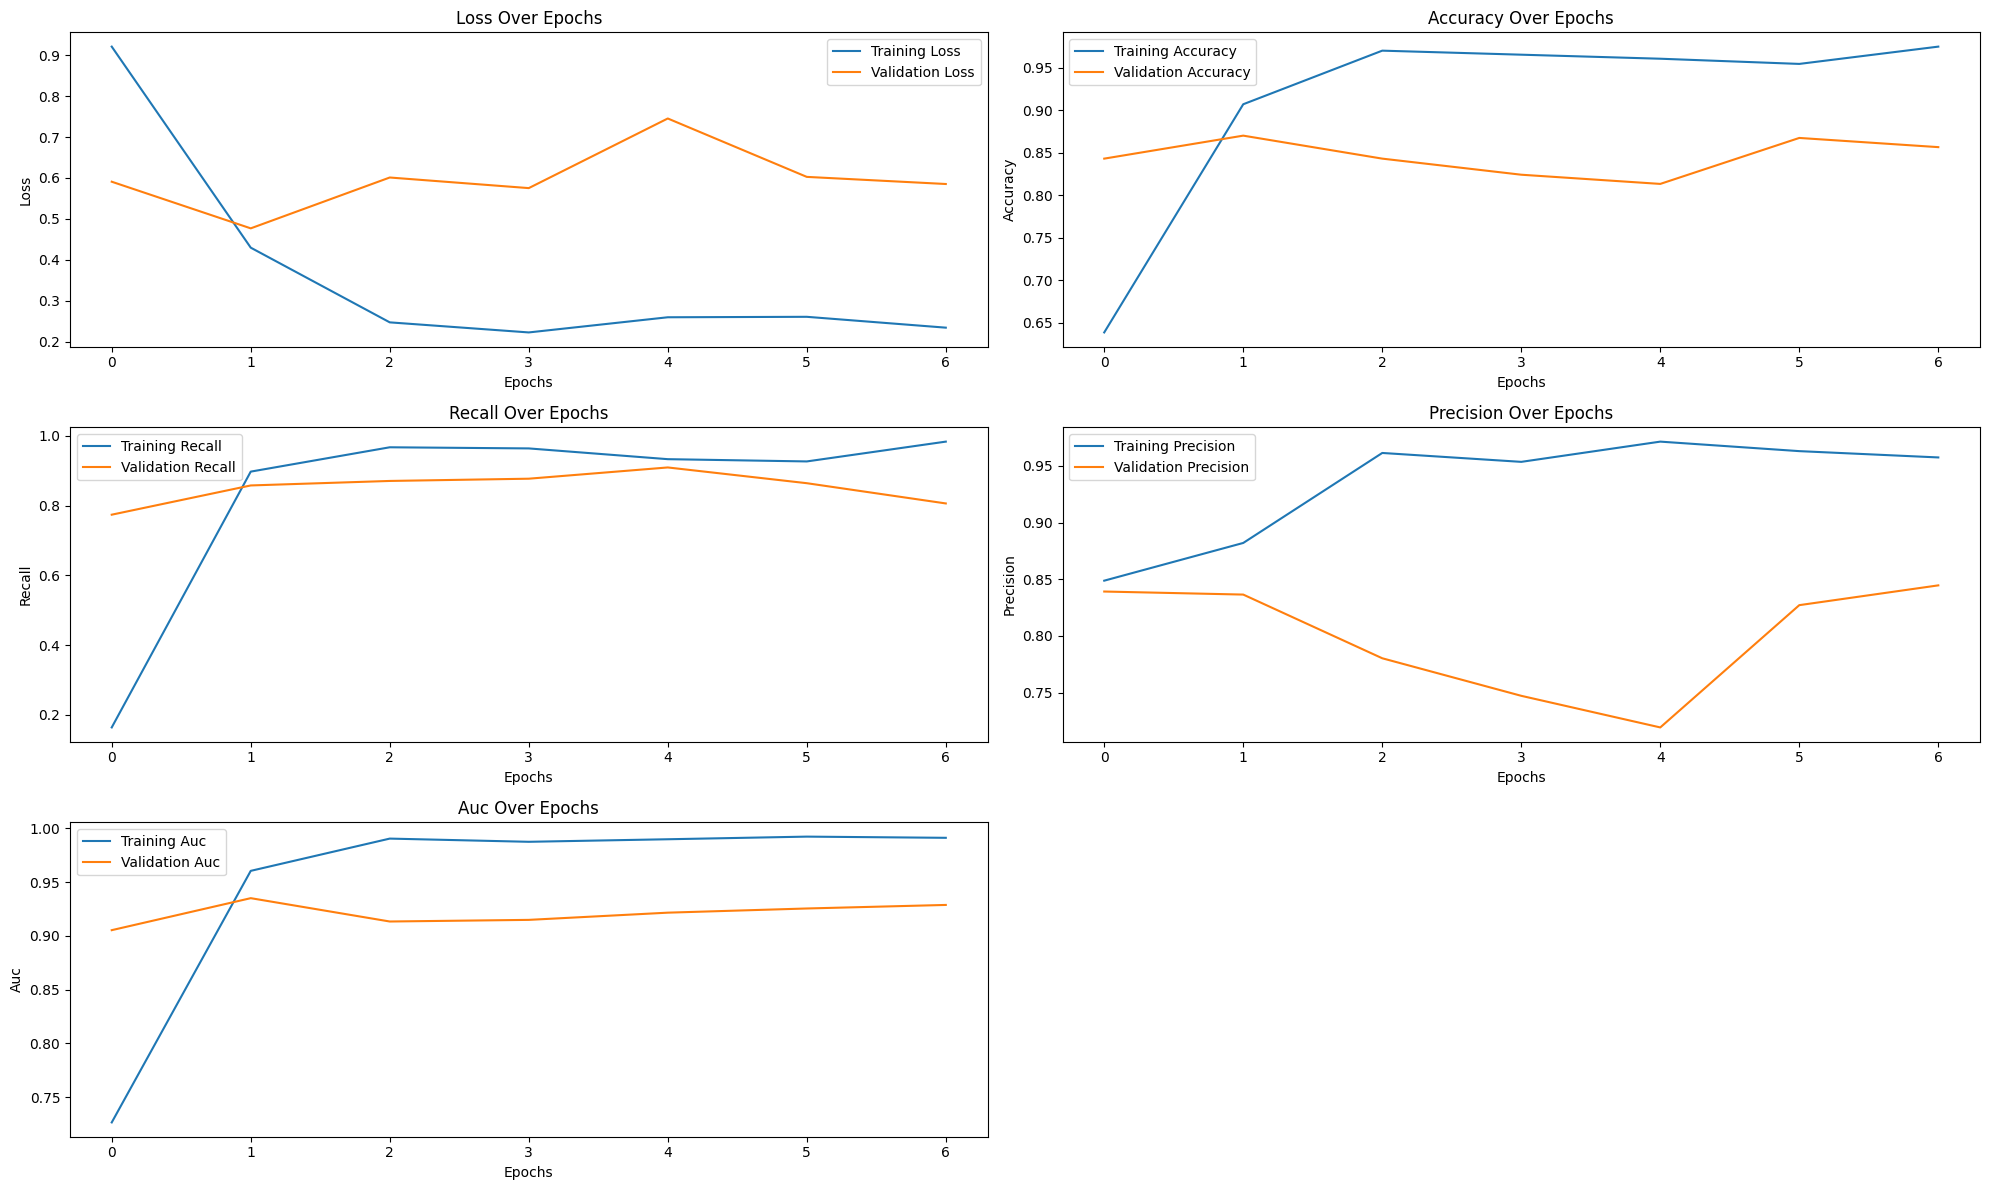


Final Training Loss: 0.2342
Final Validation Loss: 0.5852

Final Training Accuracy: 0.9749
Final Validation Accuracy: 0.8568

Final Training Recall: 0.9838
Final Validation Recall: 0.8065

Final Training Precision: 0.9573
Final Validation Precision: 0.8446

Final Training Auc: 0.9913
Final Validation Auc: 0.9288


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - AUC: 0.9330 - accuracy: 0.8467 - loss: 0.5337 - precision: 0.7615 - recall: 0.9241
{'AUC': 0.9289924502372742, 'accuracy': 0.8484848737716675, 'loss': 0.5334736704826355, 'precision': 0.7685589790344238, 'recall': 0.9119170904159546}
Test Loss: 0.5334736704826355
Test Accuracy: 0.8484848737716675
Test Recall: 0.9119170904159546
Test Precision: 0.7685589790344238
Test Auc: 0.9289924502372742


In [43]:
### Bidirectional LSTM, one layer 32 neurons, 200 embeddings, regularisation True

model_bidir_1_reg = deep_learning_utils.create_lstm_model(vectorize_layer=vectorize_layer,
                                        embedding_dim=200,
                                        lstm_units=32,
                                        num_lstm_layers=1,
                                        num_classes=1,
                                        seed=seed,
                                        dropout_rate=0.3,
                                        l2_lambda=0.001,
                                        metrics = metrics,
                                        bidirectional=True)

model_bidir_1_reg.summary()

model_description = 'One Layer Bidirectional LSTM (32), Regularisation, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_bidir_1_reg,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )